<a id="inicio"></a>
<img src="http://www.cidaen.es/assets/img/mCIDaeNnb.png" alt="Logo CiDAEN" align="right">




<br><br><br>
<h2><font color="#00586D" size=4>Capstone V (2)</font></h2>

<h1><font color="#00586D" size=5>Análisis y predicción de un conjunto de datos sobre precios de viviendas</font></h1>
<br><br><br>


<div align="right">
<font color="#00586D" size=3>Luis de la Ossa</font><br>
<font color="#00586D" size=3>Máster en Ciencia de Datos e Ingeniería de Datos en la Nube</font><br>
<font color="#00586D" size=3>Universidad de Castilla-La Mancha</font>

</div>
<br>

In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

import numpy as np
import pandas as pd

%config InlineBackend.figure_format = 'retina'
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns;
sns.set()

<a id="indice"></a>
<h2><font color="#00586D" size=5>Índice</font></h2>

#### <font color="#00586D"> Notebook I</font>
* [1. Introducción](#section1)
* [2. Preparación de los datos](#section2)
* [3. Exploración preliminar](#section3)

#### <font color="#00586D"> Notebook II</font>
* [4. Predicción con modelos básicos](#section4)
* [5. Ensembles](#section5)
* [6. Explicabilidad](#section6)
* [7. KNN](#section7)
* [8. Construcción de características](#section8)
* [9. Descarte de outliers](#section9)
* [10. Aprendizaje no supervisado: PCA, Manifold y EM](#section10)


---
<br>

En este proyecto se aborda un problema de análisis y predicción de precios de viviendas a partir de un conjunto de datos que se ha obtenido de [Kaggle](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data). En la libreta anterior, se preprocesaron estos datos y se hizo una pequeña exploración. El resultado se almacenó en el archivo  `data/houses_prep.csv`. En esta libreta se llevará a cabo el desarrollo del proyecto.

<div class="alert alert-block alert-info">
    
<i class="fa fa-info-circle" aria-hidden="true"></i>  A diferencia de proyectos anteriores, en este caso no se trabajará en pasos sucesivos hasta lograr un objetivo, sino que se resolverán ejercicios de distinta índole relacionados con algunas de las técnicas vistas en clase. Por otra parte, **aunque la lectura del proyecto es larga, los ejercicios son cortos** (relativamente 🤓).
</div>


In [2]:
data = pd.read_csv('data/houses_prep.csv', index_col=0, na_values='NA')
#df_houses.info()
data.shape

(1460, 227)

<div align="right">
<a href="#indice"><font size=5 color="#00586D"><i class="fa fa-arrow-circle-up" aria-hidden="true"></i></font></a>
</div>

---

<a id="section4"></a>
## <font color="#00586D"> 4. Predicción con modelos básicos</font>
<br>

En este apartado se implementarán unos modelos básicos iniciales sobre los que se trabajará posteriormente para intentar refinar el modelo. A continuación, se crean los conjuntos de datos de entrenamiento y test (33% de los datos). Debido a que el conjunto de datos es pequeño, se utilizará validación cruzada para seleccionar el modelo y determinar los parámetros. 

In [3]:
from sklearn.model_selection import train_test_split

X = data.drop(columns='SalePrice').copy()
y = data['SalePrice'].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)

print(X_train.shape)
print(X_test.shape)

(978, 226)
(482, 226)


Para simplificar el código se proporciona una función auxiliar que muestra los resultados de un modelo con respecto a entrenamiento, validación, y test. El parámetro `is_log` permite indicar si se ha pasado el logaritmo de la clase como variable objetivo (veremos después por qué).  Por otra parte, los resultados de los algoritmos se irán almacenando en un *DataFrame* denominado `results` con el fin de que se puedan visualizar fácilmente. Es importante que el nombre del modelo (primer parámetro de la función, `description`) sea representativo y único.

In [4]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error


# DataFrame con los resultados
results = pd.DataFrame(columns=['Modelo','$R^2$ Entrenamiento','$R^2$ Validación','$R^2$ Test', 
                                         'MAE Entrenamiento', 'MAE Test']).set_index('Modelo')
results

def show_results(description, model, X_train, y_train, X_test, y_test, is_log=False):
    train_r2 = model.score(X_train,y_train)
    val_r2 = cross_val_score(model,X_train,y_train,cv=5).mean()
    test_r2 = model.score(X_test, y_test)
    
    # Si se utiliza el logaritmo de la variable objetivo hay que 
    # convertirlo para calcular el error
    f = np.exp if is_log else lambda y: y
    # Calcula el error    
    train_mae = mean_absolute_error(f(y_train), f(model.predict(X_train)))
    test_mae = mean_absolute_error(f(y_test), f(model.predict(X_test)))
    
    # Muetra los resultados en formato legible
    print('Training \t\txValidation \t\tTest')
    print('-------- \t\t----------- \t\t----')
    print(f"R\u00B2 = {train_r2:.3f}\t\tR\u00B2 = {val_r2:.3f}\t\tR\u00B2 = {test_r2:.3f}")
    print(f"MAE = {train_mae:.2f}\t\t\t\t\tMAE = {test_mae:.2f}")
    
    results.loc[description]= (train_r2, val_r2, test_r2, train_mae, test_mae)

---

### <font color="#00586D">Regresión lineal con regularización</font>
<br>



El modelo básico con el que comenzaremos a trabajar es una regresión lineal con regularización L2 (`Ridge()`). 


#### <font color="#00586D"> <i class="fa fa-pencil-square-o" aria-hidden="true" ></i> Ejercicio 1</font> 

Entrenar un modelo `Ridge()`. Se utilizará `GridSearchCV` (con 5 particiones) para determinar el valor óptimo de `alpha`. El modelo final se almacenará en la variable `ridge`, y se mostrará el resultado con `show_results`.


<div class="alert alert-block alert-warning">
    
<i class="fa fa-exclamation-circle" aria-hidden="true"></i>
__Importante__: Para evaluar y comparar modelos **utizaremos, estrictamente,** los resultados de entrenamiento y validación cruzada. El resultado de test es informativo, y **en ningún momento lo utilizaremos para hacer ajustes**.
</div>

In [5]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge
 
parameters = {'alpha':np.logspace(-4, 4, 9, endpoint=True)}
search = GridSearchCV(Ridge(), parameters,cv=5)
search = search.fit(X_train,y_train)
print(search.best_params_, end='\n\n')

ridge = search.best_estimator_
description = 'Ridge regression'
show_results(description, ridge, X_train, y_train, X_test, y_test)

{'alpha': 10.0}

Training 		xValidation 		Test
-------- 		----------- 		----
R² = 0.908		R² = 0.846		R² = 0.776
MAE = 15187.84					MAE = 19274.55



Entrenar también un modelo `DecisionTreeRegressor` distintas configuraciones en relación a la profundidad y al número minimo de muestras por hoja. El árbol se almacenará en la variable `tree`. Mostrar los resultados.

In [6]:
from sklearn.tree import DecisionTreeRegressor

parameters = {'max_depth':np.linspace(1,15,15).astype(int), 'min_samples_split':(2,4,6,8,10)}
search = GridSearchCV(DecisionTreeRegressor(), parameters,cv=5)
search = search.fit(X_train,y_train)
print(search.best_params_, end='\n\n')

tree = search.best_estimator_
description = 'Regression tree'
show_results(description, tree, X_train, y_train, X_test, y_test)

{'max_depth': 5, 'min_samples_split': 8}

Training 		xValidation 		Test
-------- 		----------- 		----
R² = 0.876		R² = 0.714		R² = 0.734
MAE = 20723.77					MAE = 26399.47


El *DataFrame* `results`muestra ambos resultados. Comentarlos (centraos en el $R^2$ en todos los casos).

In [7]:
results

$R^2$ Entrenamiento  $R^2$ Validación  $R^2$ Test  \
Modelo                                                                
Ridge regression             0.907758          0.845827    0.775932   
Regression tree              0.875838          0.713737    0.734017   

                  MAE Entrenamiento      MAE Test  
Modelo                                             
Ridge regression       15187.837606  19274.550173  
Regression tree        20723.767792  26399.467551

___Comentario___
<br>

Se observa a partir de los resultados que el modelo de Ridge aporta un menor resultado para R2 en cuanto a entrenamiento, y un mayor resultado para validación. Puesto que la diferencia entre los resultados de entrenamiento y validacion es mas pequeña para el modelo de Ridge y además se obtiene un resultado de validación más alto, consideraremos que este modelo es más eficiente que el árbol de decisión.
<br>

<div><font size=3 color=#00586D> <i class="fa fa-check-square-o" aria-hidden="true"></i></font></div>

<!--comment -->

<div align="right">
<a href="#indice"><font size=5 color="#00586D"><i class="fa fa-arrow-circle-up" aria-hidden="true"></i></font></a>
</div>

---

<a id="section5"></a>
## <font color="#00586D"> 5. Ensembles</font>
<br>

Los ensembles, a pesar de su simplicidad (en algunos casos), son una de las técnicas más utilizadas en aprendizaje. El motivo principal es que sobreajustan menos que otros modelos. En este caso, utilizaremos un *Random Forest* para compararlo con los resultados anteriores. 

#### <font color="#00586D"> <i class="fa fa-pencil-square-o" aria-hidden="true" ></i> Ejercicio 2</font> 

Entrenar un modelo `RandomForestRegressor`, utilizando validación cruzada para estimar la máxima profundidad. Almacenar el modelo resultante en `rforest` y comentar el resultado.

In [8]:
from sklearn.ensemble import RandomForestRegressor

parameters = {'max_depth':[1,5,10,15,20]}
search = GridSearchCV(RandomForestRegressor(), parameters,cv=5)
search = search.fit(X_train,y_train)
print(search.best_params_, end='\n\n')

rforest = search.best_estimator_
description = 'Random forest'
show_results(description, rforest, X_train, y_train, X_test, y_test)

{'max_depth': 10}

Training 		xValidation 		Test
-------- 		----------- 		----
R² = 0.975		R² = 0.855		R² = 0.857
MAE = 7938.23					MAE = 17124.30


In [9]:
results

$R^2$ Entrenamiento  $R^2$ Validación  $R^2$ Test  \
Modelo                                                                
Ridge regression             0.907758          0.845827    0.775932   
Regression tree              0.875838          0.713737    0.734017   
Random forest                0.975114          0.854587    0.856982   

                  MAE Entrenamiento      MAE Test  
Modelo                                             
Ridge regression       15187.837606  19274.550173  
Regression tree        20723.767792  26399.467551  
Random forest           7938.229264  17124.295203

___Comentario___
<br>

Como podemos observar, Random forest proporciona unos valores de entrenamiento y validación mas altos que Ridge y Regression tree, por lo que sería este modelo el que mejor se ajusta a los datos.
<br>

<div><font size=3 color=#00586D> <i class="fa fa-check-square-o" aria-hidden="true"></i></font></div>

<!--comment -->


Por otra parte, El modelo *Random Forest* obtiene la importancia de las características basándose en la impureza de los árboles (aunque en el artículo original que plantea esta técnica se propone un método basado en permutaciones parecido al que ve en el tema de explicabilidad) y la almacena en el campo `feature_importances_`. A continuación, se obtiene una lista con las (por ejemplo) 20 características más importantes en la predicción y se almacenan en la lista `relevant_feat`. 


In [10]:
relevant_feat = X_train.columns[np.argsort(rforest.feature_importances_)[:-20:-1]].to_list()
print(relevant_feat)

['OverallQual', 'GrLivArea', 'TotalBsmtSF', 'BsmtFinSF1', 'GarageArea', 'GarageCars', '1stFlrSF', 'LotArea', 'BsmtQual', 'MasVnrArea', 'YearBuilt', '2ndFlrSF', 'KitchenQual', 'BsmtUnfSF', 'GarageYrBlt', 'LotFrontage', 'TotRmsAbvGrd', 'YearRemodAdd', 'OverallCond']


#### <font color="#00586D"> <i class="fa fa-pencil-square-o" aria-hidden="true" ></i> Ejercicio 3</font> 

Volver a entrenar los tres modelos anteriores, pero utilizando solamente las características relevantes (solo cambia que hay que acceder a las columnas al usar los conjuntos de training). Comentar los resultados obtenidos en relación a los obtenidos anteriormente.

In [11]:
parameters = {'alpha':np.logspace(-4, 4, 9, endpoint=True)}
search = GridSearchCV(Ridge(), parameters,cv=5)
search = search.fit(X_train[relevant_feat], y_train)
print(search.best_params_, end='\n\n')

ridge_rel = search.best_estimator_
description = 'Ridge regression (Relevant)'
show_results(description, ridge_rel, X_train[relevant_feat], y_train, X_test[relevant_feat], y_test)

{'alpha': 10.0}

Training 		xValidation 		Test
-------- 		----------- 		----
R² = 0.839		R² = 0.826		R² = 0.716
MAE = 20409.53					MAE = 21976.68


In [12]:
parameters = {'max_depth':np.linspace(1,15,15), 'min_samples_split':(2,4,6,8,10)}
search = GridSearchCV(DecisionTreeRegressor(), parameters,cv=5)
search = search.fit(X_train[relevant_feat],y_train)
print(search.best_params_, end='\n\n')

tree_rel = search.best_estimator_
description = 'Regression tree (Relevant)'
show_results(description, tree_rel, X_train[relevant_feat], y_train, X_test[relevant_feat], y_test)

{'max_depth': 8.0, 'min_samples_split': 10}

Training 		xValidation 		Test
-------- 		----------- 		----
R² = 0.953		R² = 0.722		R² = 0.685
MAE = 13021.63					MAE = 24963.96


In [13]:
parameters = {'max_depth':[1,5,10,15,20]}
search = GridSearchCV(RandomForestRegressor(), parameters,cv=5)
search = search.fit(X_train[relevant_feat],y_train)
print(search.best_params_, end='\n\n')

rforest_rel = search.best_estimator_
description = 'Random forest (Relevant)'
show_results(description, rforest_rel, X_train[relevant_feat], y_train, X_test[relevant_feat], y_test)

{'max_depth': 20}

Training 		xValidation 		Test
-------- 		----------- 		----
R² = 0.979		R² = 0.850		R² = 0.861
MAE = 6744.09					MAE = 17421.19


In [14]:
results

$R^2$ Entrenamiento  $R^2$ Validación  \
Modelo                                                               
Ridge regression                        0.907758          0.845827   
Regression tree                         0.875838          0.713737   
Random forest                           0.975114          0.854587   
Ridge regression (Relevant)             0.838920          0.826211   
Regression tree (Relevant)              0.952891          0.722274   
Random forest (Relevant)                0.979456          0.850222   

                             $R^2$ Test  MAE Entrenamiento      MAE Test  
Modelo                                                                    
Ridge regression               0.775932       15187.837606  19274.550173  
Regression tree                0.734017       20723.767792  26399.467551  
Random forest                  0.856982        7938.229264  17124.295203  
Ridge regression (Relevant)    0.716225       20409.525417  21976.678936  
Regression tree (Relevant)     0.684827       13021.630030  24963.960631  
Random forest (Relevant)       0.860595        6744.088366  17421.191491

___Comentario___
<br>

Podemos observar que, a partir de la selección de datos relevantes:
<br>
    -Ridge: desciende su valor en R2 para el entrenamiento y validacion pero la diferencia de eficacia entre entrenamiento y validación es menor.
<br>
    -Árbol de regresión y Random forest: Sus valores se mantienen a partir de la selección de los datos relevantes (descendiendo ligeramente).
Es por ello que podemos considerar que el modelo de Ridge es el más sensible a la modificación de los datos cuando seleccionamos solo los relevantes.
<br>

<div><font size=3 color=#00586D> <i class="fa fa-check-square-o" aria-hidden="true"></i></font></div>

<!--comment -->

<div align="right">
<a href="#indice"><font size=5 color="#00586D"><i class="fa fa-arrow-circle-up" aria-hidden="true"></i></font></a>
</div>

---

<a id="section6"></a>
## <font color="#00586D"> 6. Explicabilidad</font>
<br>


En el análisis previo del modelo *Random Forest* hemos visto cuáles son las características más importantes (según la impureza de las mismas [**(+ inf)**](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html#sklearn.ensemble.RandomForestRegressor.feature_importances_). Para hacer una evaluación global de los resultados, nos interesa ver la relación de las variables `OverallQual` y `GrLivArea` con las predicciones obtenidas en el conjunto de test.

#### <font color="#00586D"> <i class="fa fa-pencil-square-o" aria-hidden="true" ></i> Ejercicio 4</font> 

Dibuja un gráfico de dependencia parcial (PDP) para las variables `OverallQual` y `GrLivArea` (tanto por separado, como de ambas variables juntas). Utiliza el modelo almacenado en `rforest` (entrenado anteriormente) y  `method='brute'` para que el cálculo se realice con la misma aproximación que vista en clase. ¿Cuál es la relación de estas variables con los valores de la salida?

In [15]:
X_test.columns.get_indexer(["OverallQual","GrLivArea"]) #hallamos el número de feature que tienen ambas variables

array([ 2, 14], dtype=int64)

C:\Users\laura\anaconda3\lib\site-packages\sklearn\inspection\_partial_dependence.py:154: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  X_eval.iloc[:, variable] = new_values[i]


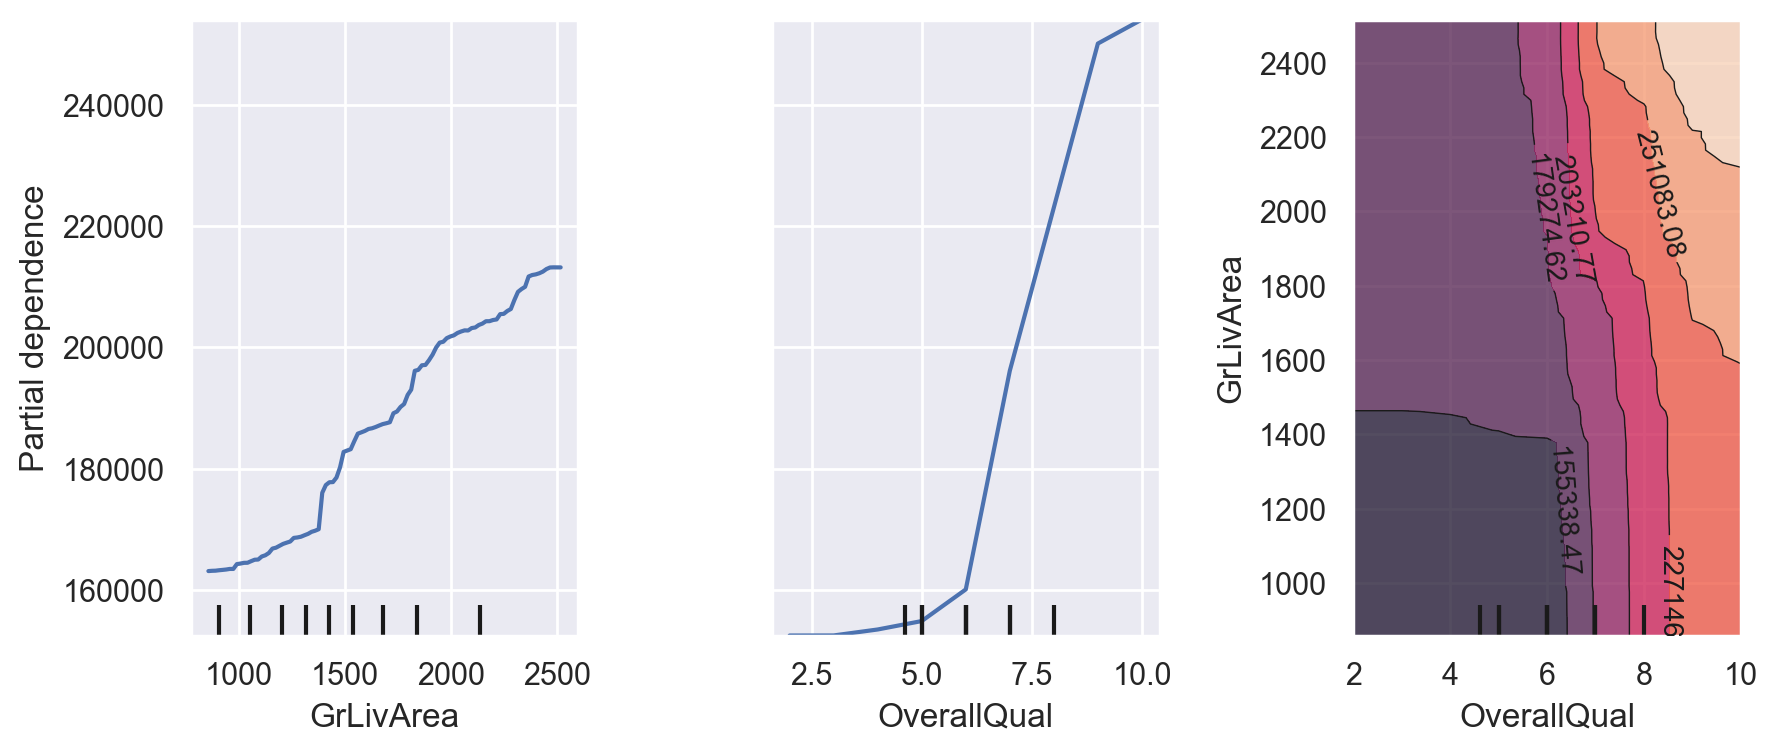

In [16]:
from sklearn.inspection import PartialDependenceDisplay

plt.figure(figsize=(10,4))
ax = plt.gca()

#clf = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0)
#clf.fit(X_train, y_train)

features = [14, 2, (2, 14)]
# COMPLETAR
PartialDependenceDisplay.from_estimator(rforest, X_test, features, method="brute", ax=ax)

plt.subplots_adjust(wspace=0.5)

___Comentario___
<br>

Podemos observar en los dos primeros gráficos que conforme la variable crece aumenta el valor de la predicción. Para la variable OverallQual observamos un aumento significativo del valor de la predicción a partir del valor 6 conforme aumenta la variable OverallQual
<br>
En el plot de dpendencia parcial podemos observar que en la parte de 0-6 para OverallQual los valores dependen de que la variable GrLivArea sea mayor o menor que 1500. Sin embargo, a partir del valor 6 hasta el valor 7.5 para OverallQual podemos observar que los valores solo dependen de esta variable (OverallQual) y a partir del valor 7.5 para OverallQual la dependencia predomina en la variable GrLivArea aunque se mantiene cierta dependencia para OverallQual




<div><font size=3 color=#00586D> <i class="fa fa-check-square-o" aria-hidden="true"></i></font></div>

<!--comment -->

El gráfico anterior nos permite visualizar de forma global la relación de las variables con la salida. Imaginemos ahora que nos encontramos en la siguiente situación: una persona quiere poner a la venta su vivienda, pero el precio de venta que predecimos es más bajo del esperado. ¿Podemos explicarle el motivo de dicho resultado?


En este caso, se pretende expicar por qué obtenemos una predicción específica para una muestra específica. En estos casos, podemos utilizar SHAP para estudiar cómo los valores de las distintas variables afectan a la salida.

In [17]:
!pip install shap

In [18]:
import shap

shap.initjs()

Vamos a estudiar algunas muestras individuales del conjunto de test para simular distintas situaciones. En concreto, vamos a seleccionar las muestras más cercanas a los percentiles 0, 0.25, 0.5, 0.75 y 1 (en cuanto a valor de *y*) en las predicciones del conjunto de test. El 0 corresponderá a la muestra con la predicción de precio más bajo, mientras que 1 sería la muestra de test con la predicción más alta.

In [19]:
y_pred = rforest.predict(X_test)
pcen = np.percentile(y_pred, [0, 25, 50, 75, 100], method='nearest')
i_near = [abs(y_pred - i).argmin() for i in pcen]
samples = X_test.iloc[i_near, :]
samples.head()

LotFrontage  LotArea  OverallQual  OverallCond  YearBuilt  YearRemodAdd  \
Id                                                                              
1101         60.0     8400            2            5       1920          1950   
143          71.0     8520            5            4       1952          1952   
56          100.0    10175            6            5       1964          1964   
114          69.0    21000            6            5       1953          1953   
1183        160.0    15623           10            5       1996          1996   

      MasVnrArea  BsmtFinSF1  BsmtFinSF2  BsmtUnfSF  ...  SaleType_ConLw  \
Id                                                   ...                   
1101         0.0         290           0          0  ...               0   
143          0.0         507           0        403  ...               0   
56         272.0         490           0        935  ...               0   
114        184.0          35         869        905  ...               0   
1183         0.0        2096           0        300  ...               0   

      SaleType_New  SaleType_Oth  SaleType_WD  SaleCondition_Abnorml  \
Id                                                                     
1101             0             0            1                      0   
143              0             0            1                      0   
56               0             0            1                      0   
114              0             0            0                      1   
1183             0             0            1                      1   

      SaleCondition_AdjLand  SaleCondition_Alloca  SaleCondition_Family  \
Id                                                                        
1101                      0                     0                     0   
143                       0                     0                     0   
56                        0                     0                     0   
114                       0                     0                     0   
1183                      0                     0                     0   

      SaleCondition_Normal  SaleCondition_Partial  
Id                                                 
1101                     1                      0  
143                      1                      0  
56                       1                      0  
114                      0                      0  
1183                     0                      0  

[5 rows x 226 columns]

#### <font color="#00586D"> <i class="fa fa-pencil-square-o" aria-hidden="true" ></i> Ejercicio 5</font> 

Dibujar los gráficos de fuerzas SHAP para cada una de las 5 muestras seleccionadas. Comentar los resultados.

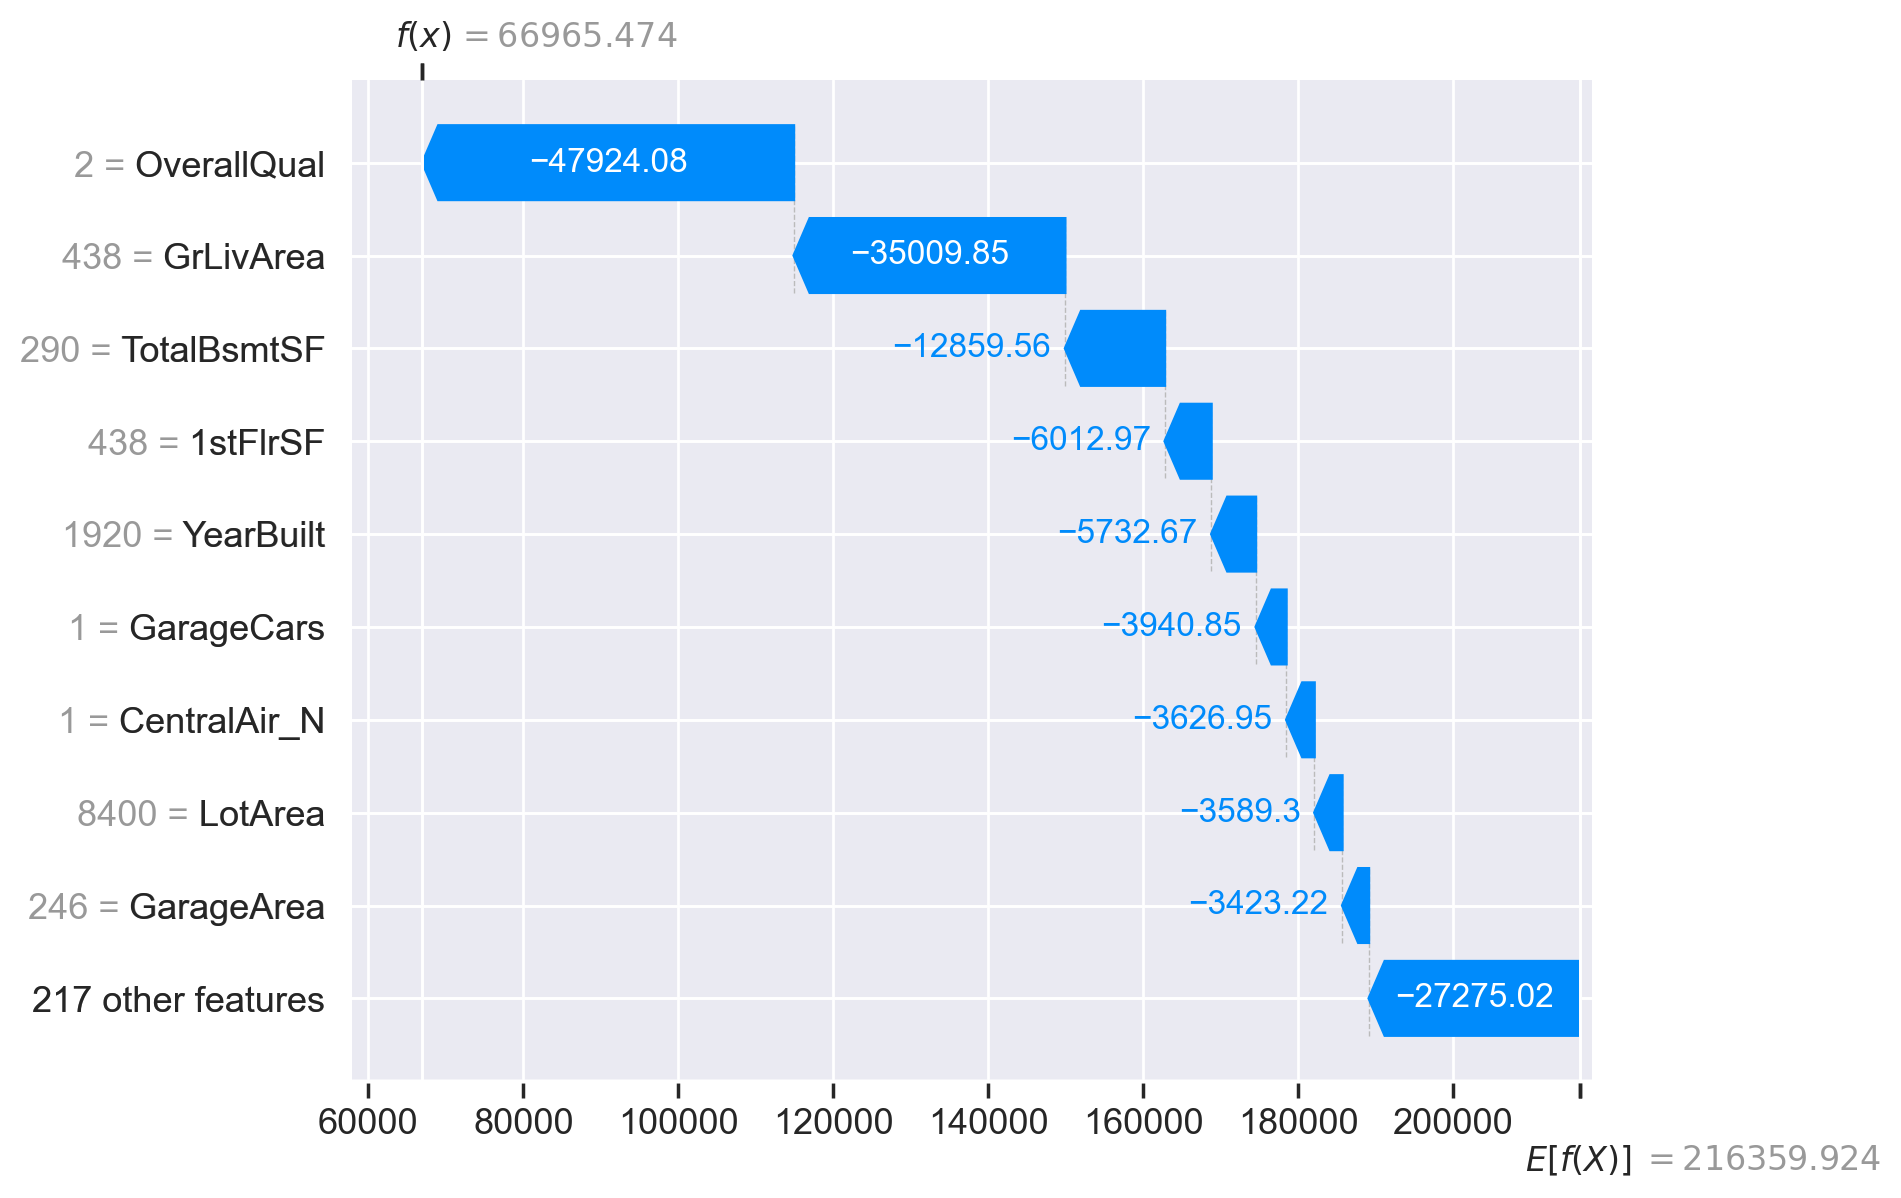

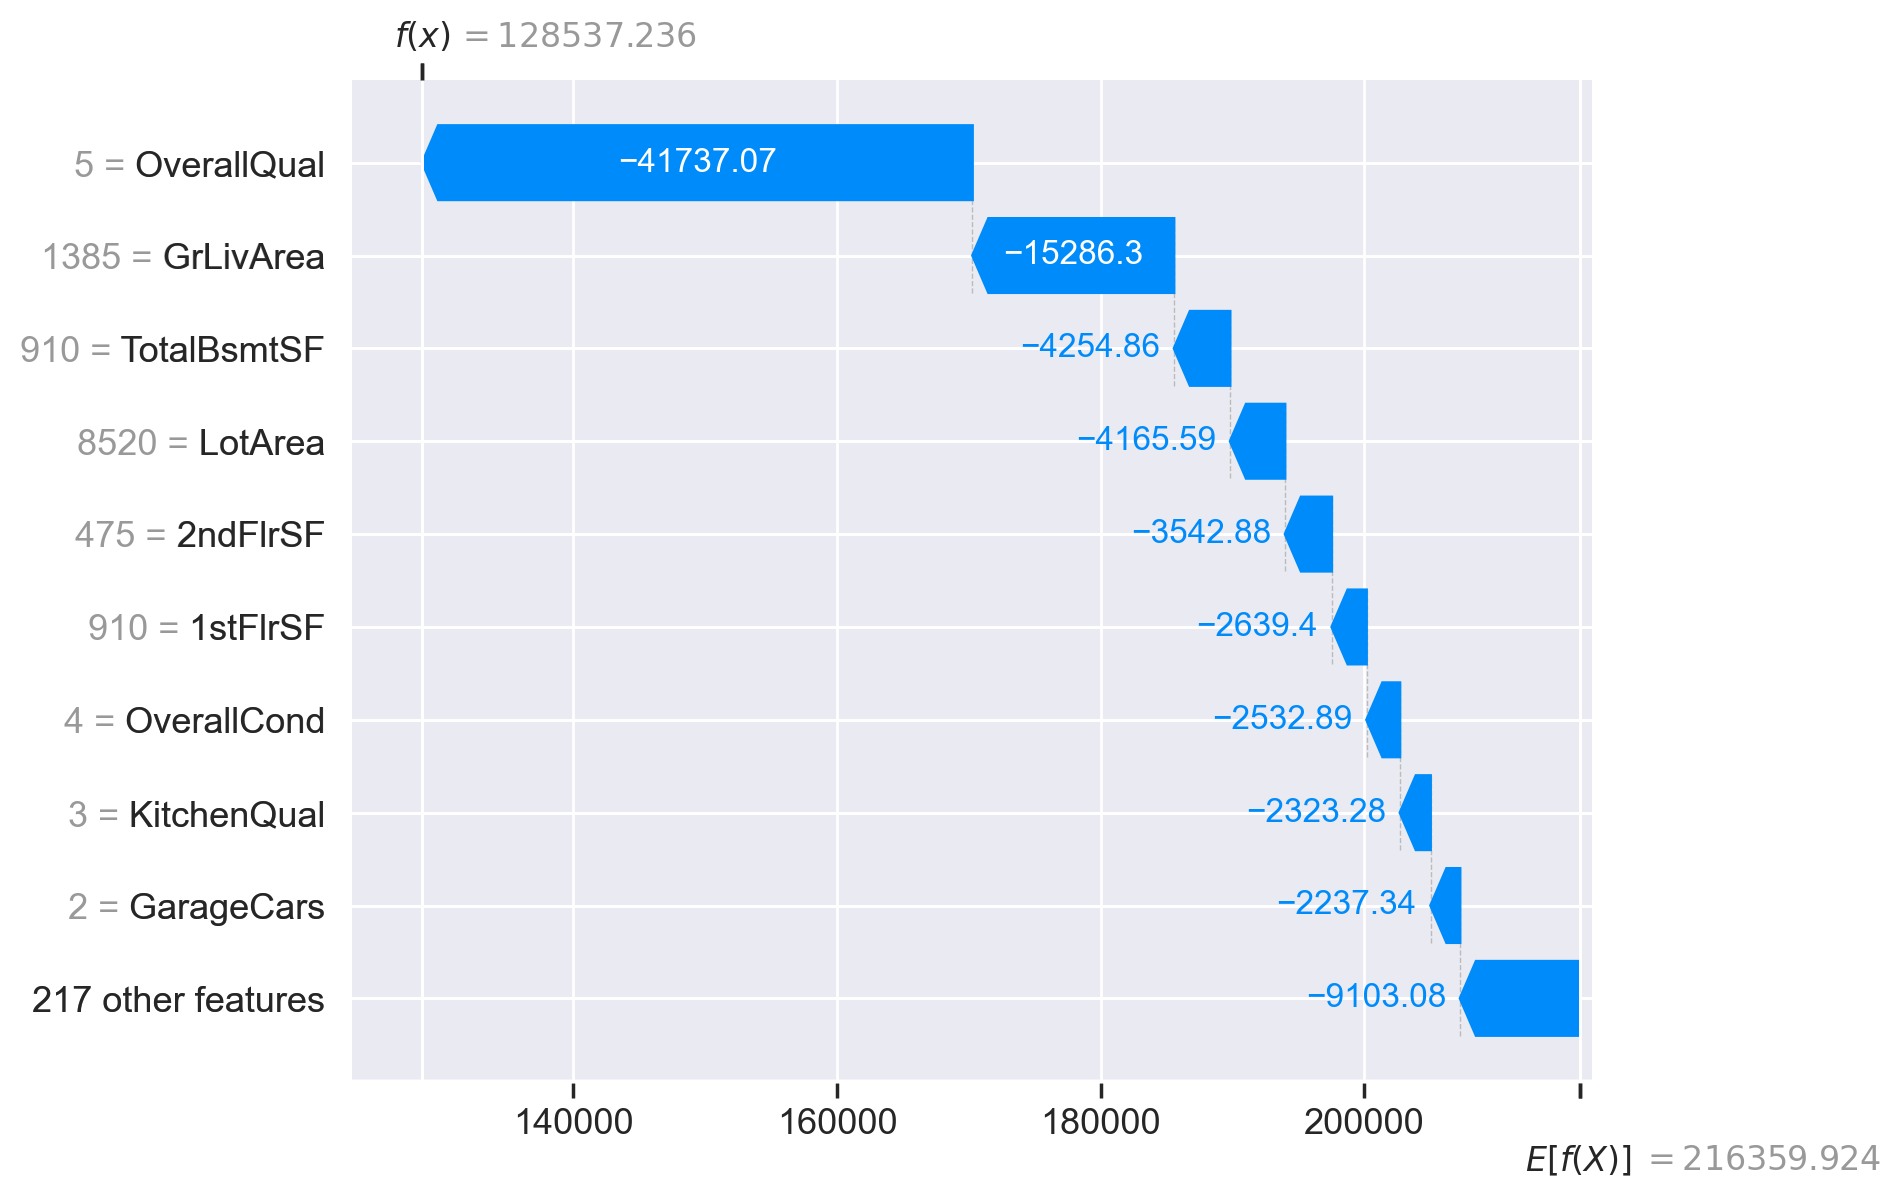

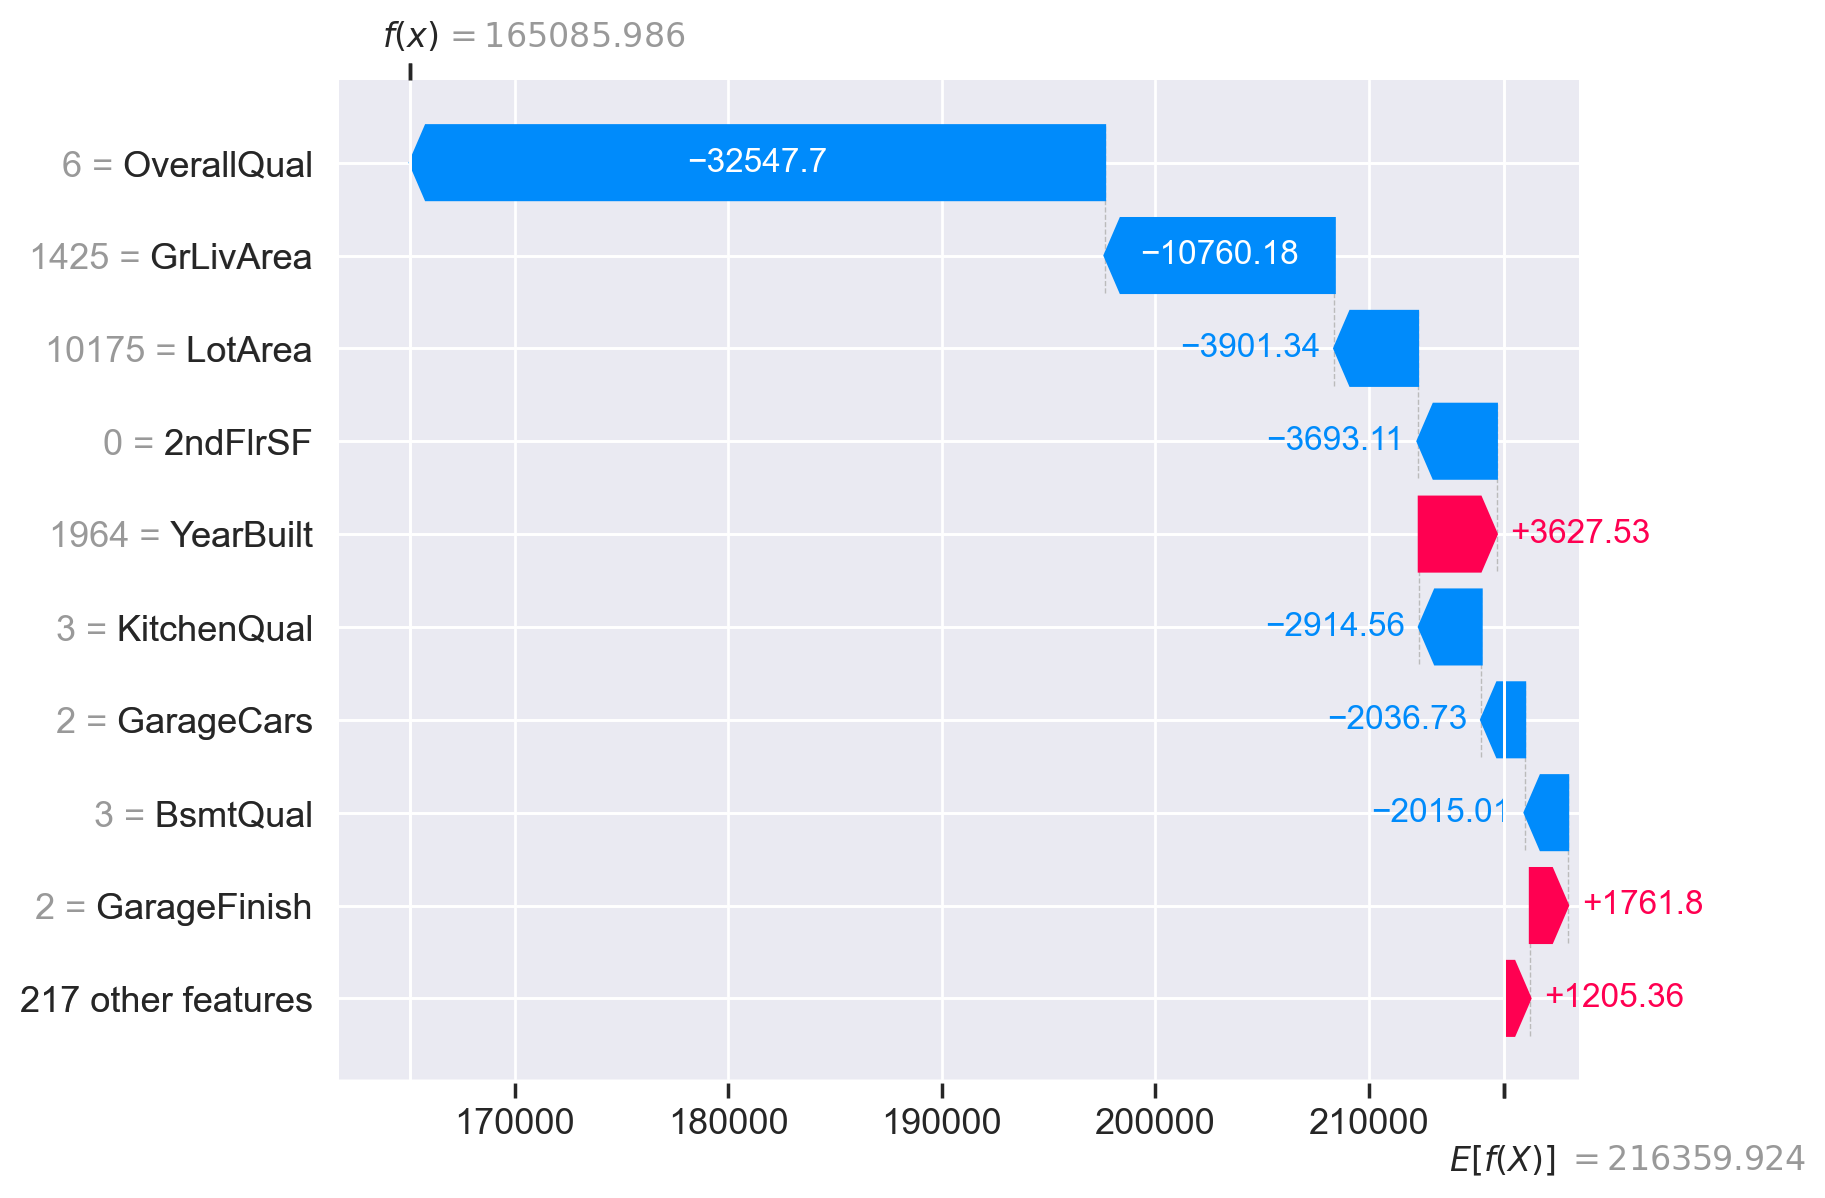

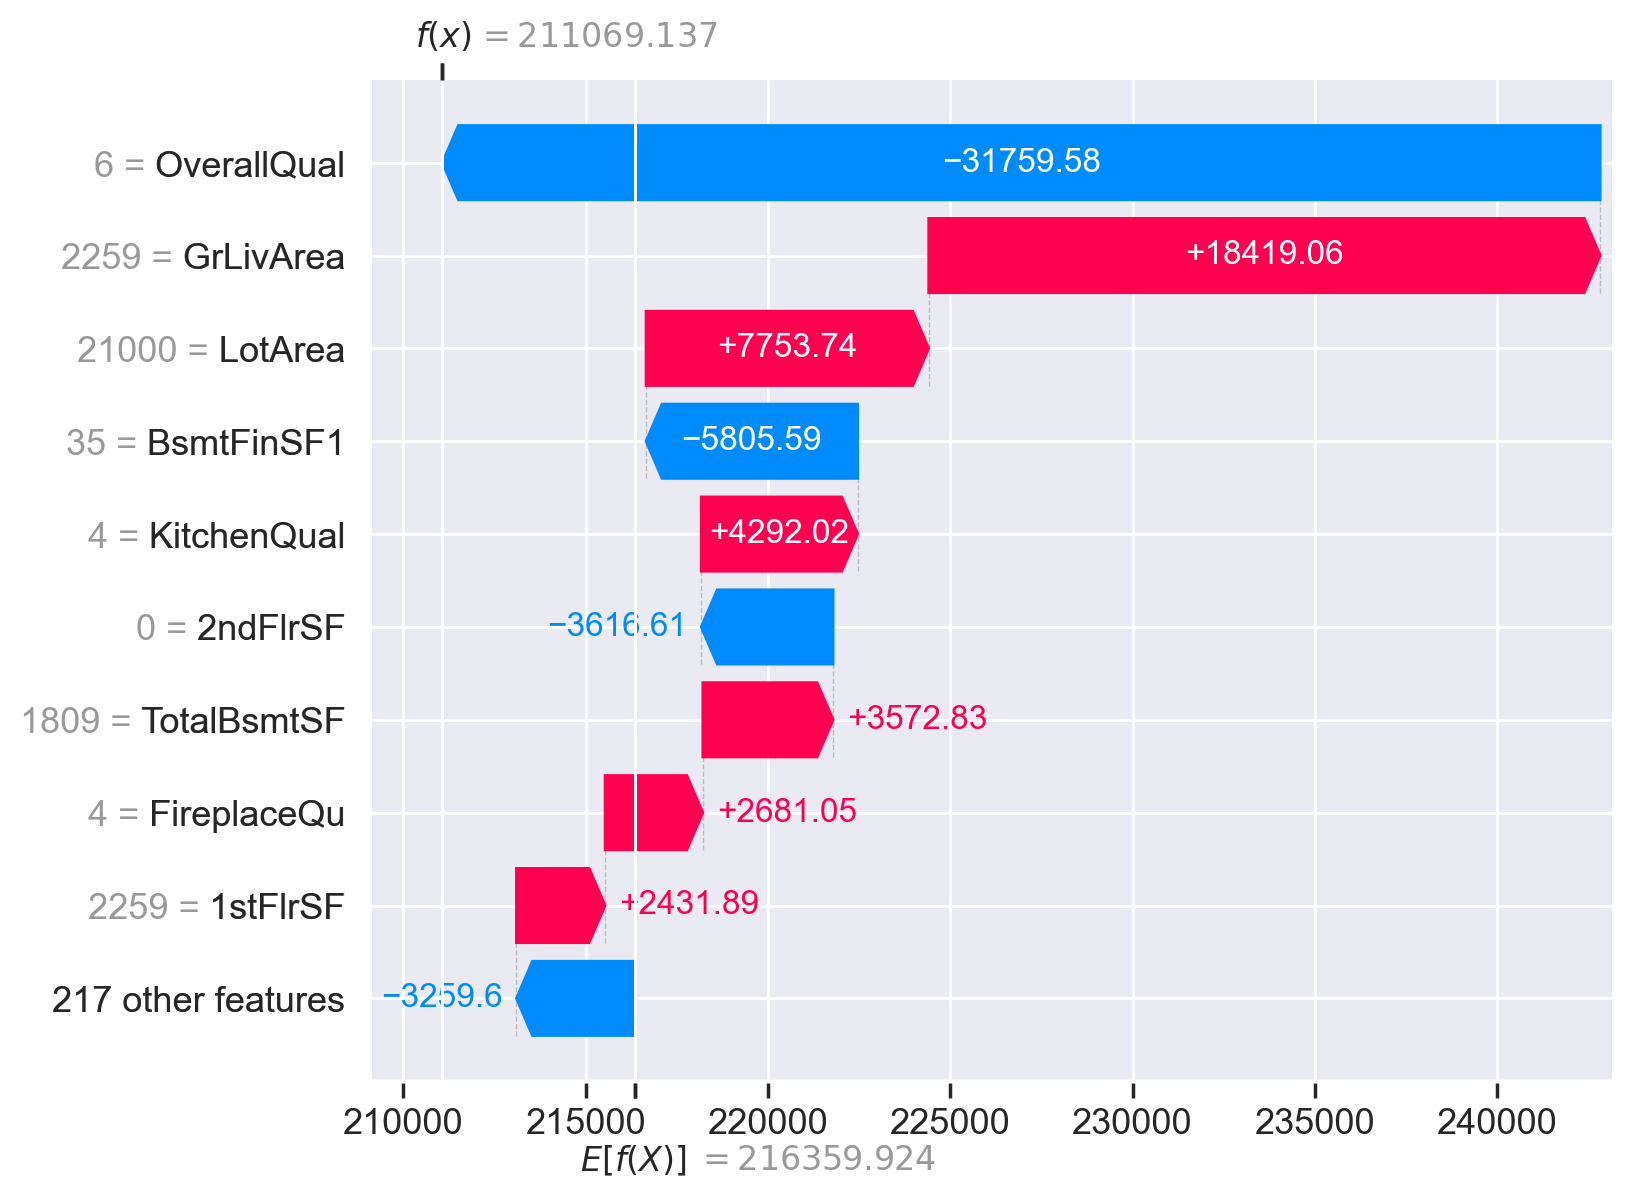

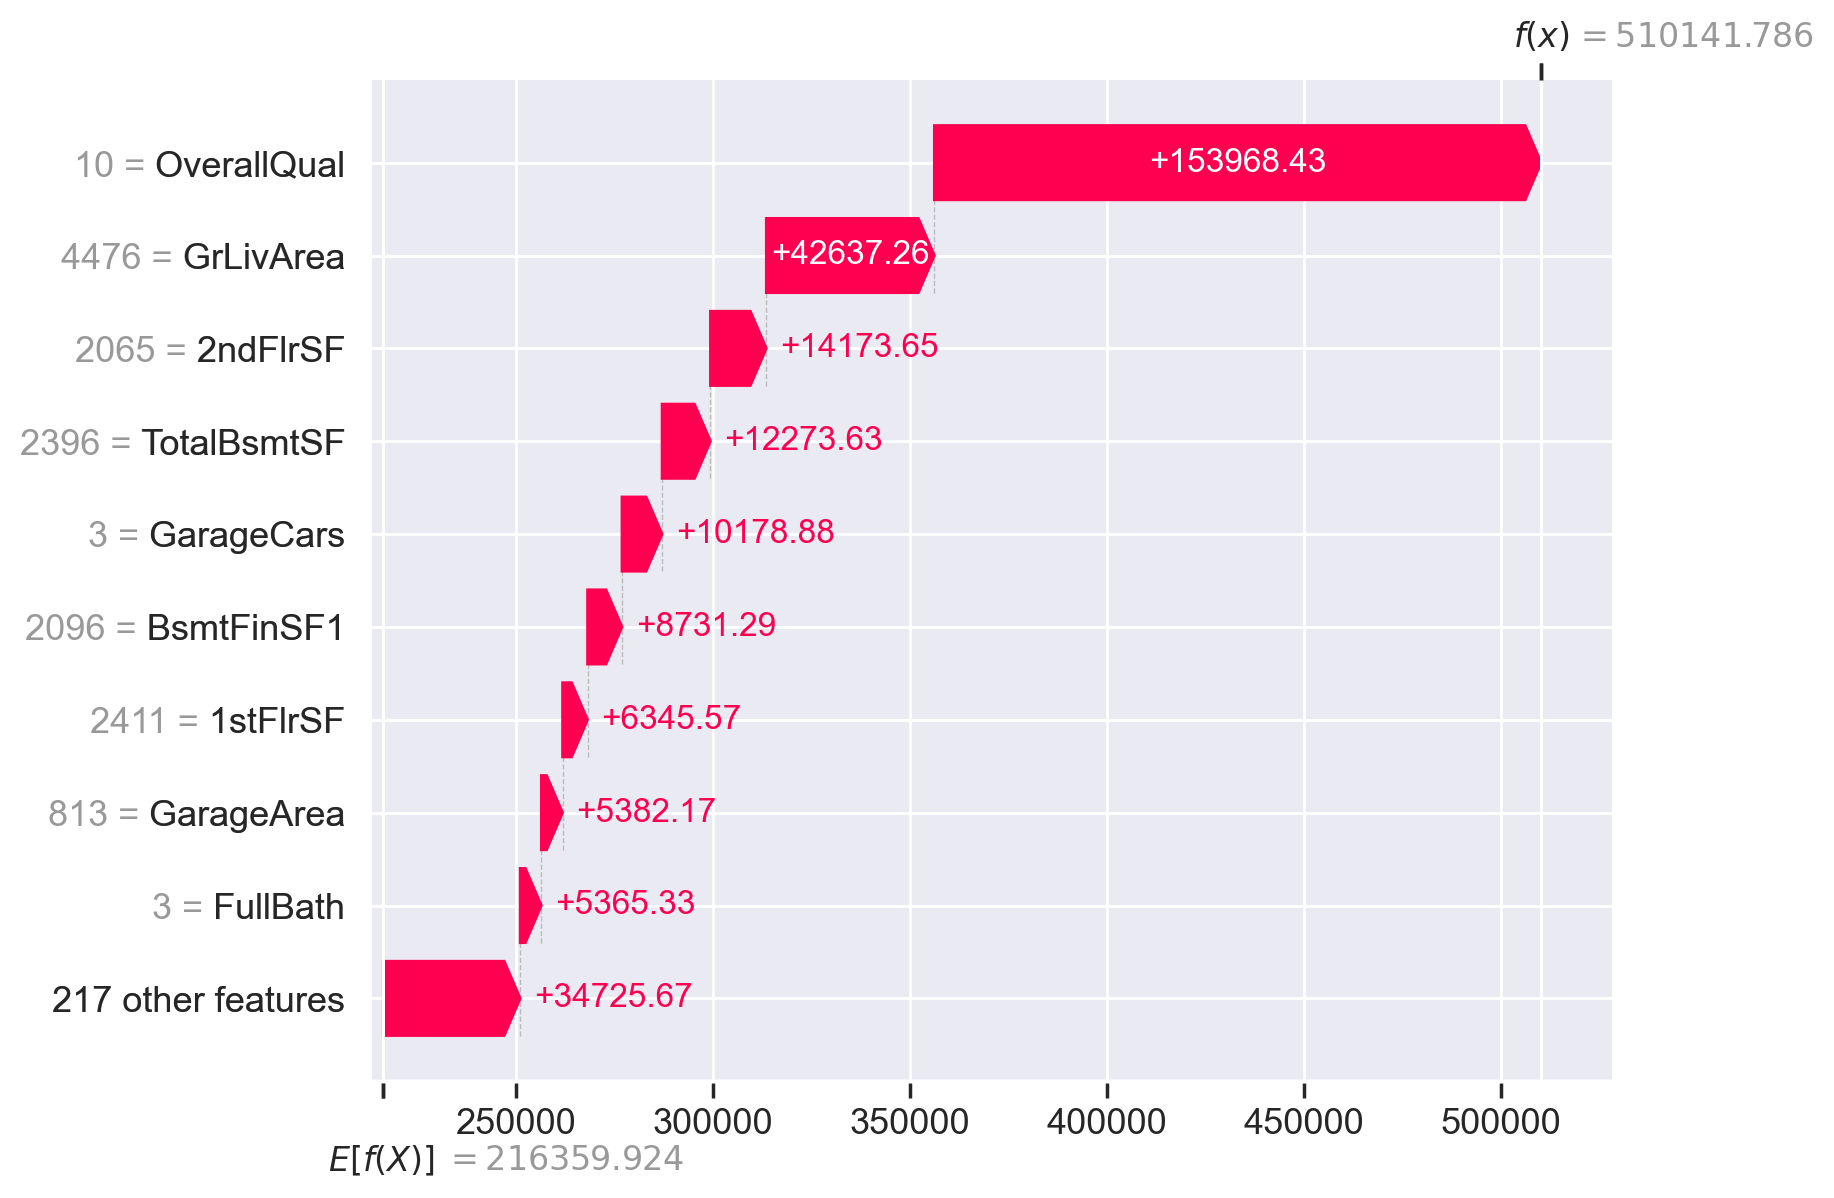

In [20]:
explainer = shap.Explainer(rforest,samples)
shap_values = explainer(samples)
shap.plots.waterfall(shap_values[0])
shap.plots.waterfall(shap_values[1])
shap.plots.waterfall(shap_values[2])
shap.plots.waterfall(shap_values[3])
shap.plots.waterfall(shap_values[4])


In [21]:
sample = 0
shap.plots.force(shap_values[0])
# COMPLETAR

In [22]:
sample = 1
shap.plots.force(shap_values[1])
# COMPLETAR

In [23]:
sample = 2
shap.plots.force(shap_values[2])
# COMPLETAR

In [24]:
sample = 3
shap.plots.force(shap_values[3])
# COMPLETAR

In [25]:
sample = 4
shap.plots.force(shap_values[4])
# COMPLETAR

___Comentario___
<br>

Las gráficas waterfall nos dicen para cada muestra cómo contribuyen las variables a la predicción, donde los valores altos (respecto a la media) positivos o negativos indican un alto impacto en la predicción del modelo. 
<br>
Una manera de representar los gráficos waterfal más condensados son los gráficos de fuerza, donde se observa cómo cada variable contribuye al valor de la predicción final. 
<br>
En este caso podemos observar que para la primera muestra las variables desplazan los valores SAP por fuerza negativa hacia la izquierda y las variables próximas al centro son las que mayor influencia tienen (OverallQual,GrLivArea). El valor final obtenido para esta muestra es de 67618.
<br>
Para la segunda muestra la situación es similar a la primera, el valor SAP se encuentra desplazado por fuerza negativa hacia la izquierda pero esta fuerza es causada por variables diferentes a las del primer caso (siendo las mas influyentes OverallQual y LotArea). Para esta muestra existe una leve fuerza positiva que genera que el valor sea más alto que en el caso anterior (adquiriendo un valor de 128699 siendo el valor base es 200000)
<br>
En el caso de la tercera muestra observamos que existe mayor influencia de muestras negativas que positivas y por ello el valor aumenta (adquiriendo un valor de 164155). Las variables que mayor influencia tienen en fuerzas negativas son OverallQual y GrLivArea y la variable con mayor influencia para las fuerzas positivas es YearRemodAdd.
<br>
Para la cuarta muestra observamos que el valor se encuentra cerca del valor base (obteniendo un valor de 210558) ligeramente desplazado hacia la derecha por las fuerzas positivas, siendo las variables mas influyentes GrLivArea y LotArea. Para las fuerzas negativas la variable más influyente es OverallQual.
<br>
Con respecto a la quinta muestra se observa que está desplazada hacia la derecha debido a fuerzas positivas provenientes de las variables OverallQual y GrLivArea. Para esta muestra se obtiene un valor de 476669.
<br>
A partir de todo esre análisis se comprueba que la variable común más influyente para todas las muestras es OverallQual 

<div><font size=3 color=#00586D> <i class="fa fa-check-square-o" aria-hidden="true"></i></font></div>

<!--comment -->

#### <font color="#00586D"> <i class="fa fa-pencil-square-o" aria-hidden="true" ></i> Ejercicio 6</font> 

Dibuja un resumen global de los valores SHAP de todas las muestras de test con `summary_plot`. Comentar los resultados.

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


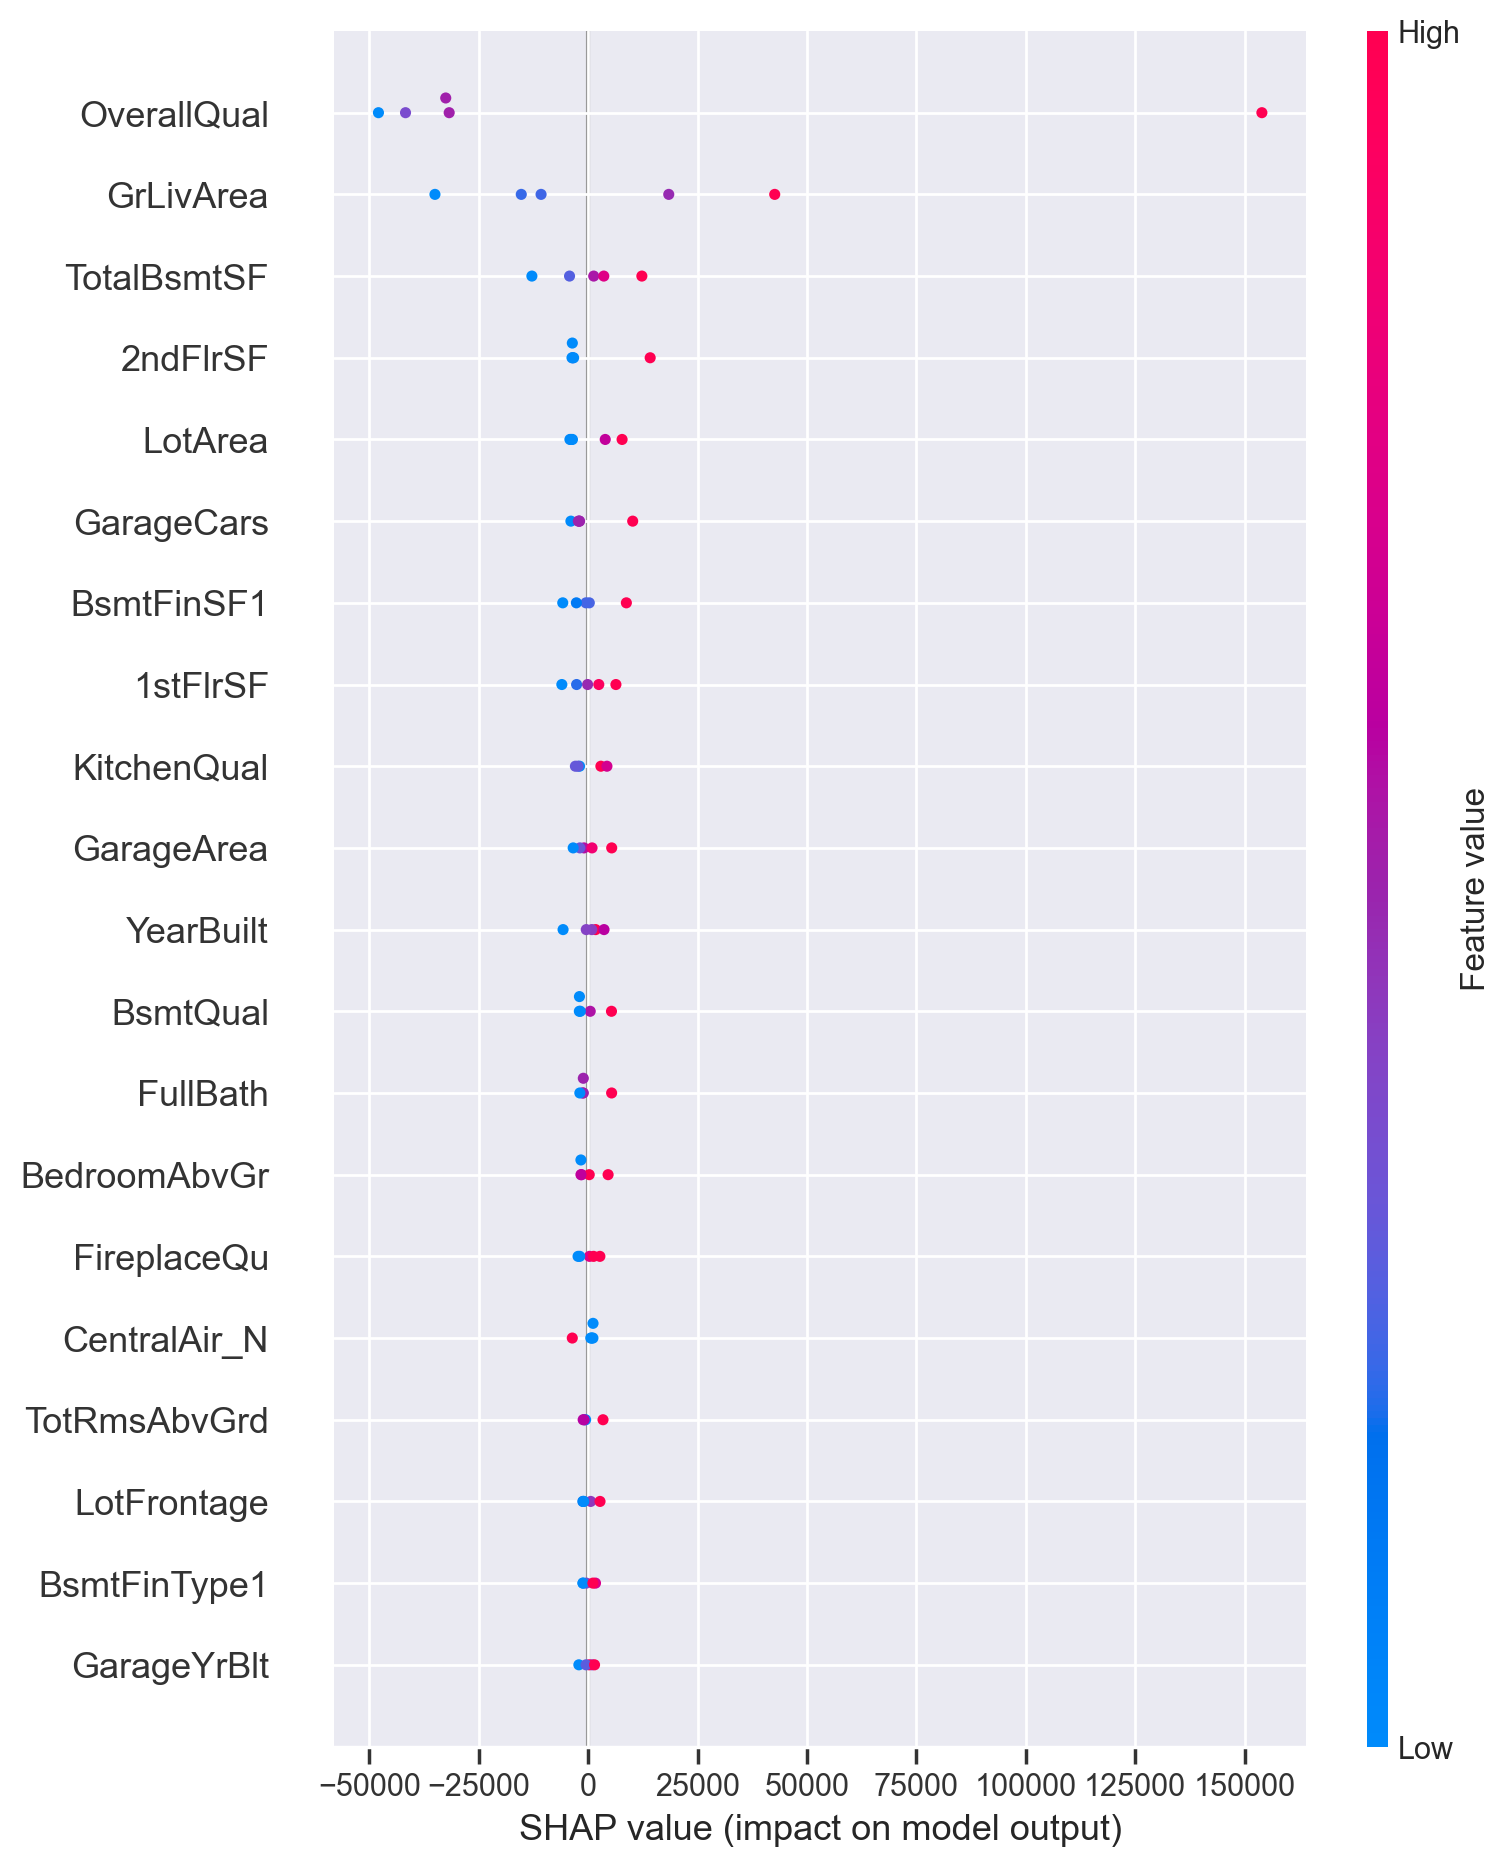

In [26]:
shap.summary_plot(shap_values, samples, show=False)

___Comentario___
<br>

A partir del gráfico podemos observar que:
<br>
- Para la característica OverallQual la muestra con mayor valor se encuentra entre los valores de SHAP 125000-150000, mientras que las muestras con menores valores se encuentran en un SHAP por debajo de 0.
<br>
- para la variable GrLivArea la muestra con mayor valor se encuentra en un SHAP de entre 25000-50000, mientras que las muestras con menores valores se encuentran en un SHAP por debajo de 25000.
<br>
- para las características GarageCars, 2ndFlrSF, BsmtFinSF1, TotalBsmtSF y GarageArea observamos que la muestra con mayor valor se encuentra aproximadamente en un valor SHAP de 17500, mientras que las muestras con valores bajos se encuentran en un valor SHAP cercano a 0.
<br>
- Para el resto de características se observa que todas las muestras se situan en un valor SHAP cercano a 0.


<div><font size=3 color=#00586D> <i class="fa fa-check-square-o" aria-hidden="true"></i></font></div>

<!--comment -->

<div align="right">
<a href="#indice"><font size=5 color="#00586D"><i class="fa fa-arrow-circle-up" aria-hidden="true"></i></font></a>
</div>

---

<a id="section7"></a>
## <font color="#00586D"> 7. KNN</font>
<br>

Anteriormente se han usado algunos métodos paramétricos (regresión) y no paramétricos (árboles y *Random Forest*) para la predicción. KNN es otro método no paramétrico muy sencillo.


#### <font color="#00586D"> <i class="fa fa-pencil-square-o" aria-hidden="true" ></i> Ejercicio 7</font> 

Entrenar un modelo de predicción utilizando el vecino más cercano. Como el conjunto de datos no es excesivamente alto en relación a las características, y este algoritmo es muy sensible a la "*Maldición de la dimensionalidad"*, en esta prueba se utilizarán solamente las características numéricas relevantes obtenidas anteriormente con *Random Forest*, y almacenadas en `relevant_feat` durante el proceso de exploración.  

In [27]:
from sklearn.neighbors import KNeighborsRegressor

knn = KNeighborsRegressor()
k=1
knn.set_params(n_neighbors = k)
knn.fit(X_train[relevant_feat], y_train)

description = '1-NN (Relevant)'
show_results(description, knn, X_train[relevant_feat], y_train, X_test[relevant_feat], y_test)

Training 		xValidation 		Test
-------- 		----------- 		----
R² = 1.000		R² = 0.503		R² = 0.610
MAE = 14.67					MAE = 32802.02


Puede apreciarse que el rendimiento de este algoritmo es muy pobre ($R^2=0.504$ en validación). A continuación se creará un *pipeline* para estandarizar los datos antes de hacer la predicción.

In [28]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

pipe_knn = Pipeline([('scaler', StandardScaler()),('knn',KNeighborsRegressor())])
pipe_knn.fit(X_train[relevant_feat], y_train)


description = '1-NN (Relevant-STD)'
show_results(description, pipe_knn, X_train[relevant_feat], y_train, X_test[relevant_feat], y_test)

Training 		xValidation 		Test
-------- 		----------- 		----
R² = 0.889		R² = 0.816		R² = 0.782
MAE = 16135.72					MAE = 20657.93


En este caso, sube de manera sustancial el $R^2$ para el conjunto de validación. ¿Qué sucece?

___Comentario___
<br>

Un pipeline es una manera de automatizar el flujo de trabajo del aprendizaje automático.
<br>
En este pipeline hemos utilizado standardscaler como método de preprocesamiento de los datos para eliminar la media y escalar los datos de manera que la varianza sea igual a 1. Después del procesamiento de los datos, se utiliza el modelo y se entrena con los datos de entrenamiento. Se puede observar que cuando realizamos el pipeline, el resultado de R para la validacion es mayor y para el training es mayor, eso significa que cuando hacemos el pipeline estamos reduciendo el sobreajuste (cuando no se hace un standardscaler R es 1 para training y 0.5 para validacion, lo que significa que el modelo no está generalizando bien ya que cuando le das nuevos datos R decrece sustancialmente)
<br>

<div><font size=3 color=#00586D> <i class="fa fa-check-square-o" aria-hidden="true"></i></font></div>

<!--comment -->

#### <font color="#00586D"> <i class="fa fa-pencil-square-o" aria-hidden="true" ></i> Ejercicio 8</font> 

Analizar el funcionamiento de KNN con distintos valores para `k`, utilizando pesos uniformes o inversos a la distancia para agregar los valores de los vecinos. En primer lugar, utilizando **todas las variables** (`X_train`) y estandarización.

In [29]:
pipe_knn = Pipeline([('scaler', StandardScaler()),('knn',KNeighborsRegressor())])

parameters = {'knn__n_neighbors':(1,5,10,15,20), 'knn__weights':('uniform','distance')}
search = GridSearchCV(pipe_knn, parameters, cv=5)
search = search.fit(X_train,y_train)
print(search.best_params_, end='\n\n')

knn = search.best_estimator_
description = 'k-NN (STD)'
show_results(description, knn, X_train, y_train, X_test, y_test)

{'knn__n_neighbors': 10, 'knn__weights': 'distance'}

Training 		xValidation 		Test
-------- 		----------- 		----
R² = 1.000		R² = 0.732		R² = 0.698
MAE = 0.01					MAE = 25710.12


Puede hacerse la predicción utilizando solamente las características relevantes obtenidas con `Random Forest` (`relevant_feat`).

In [30]:
pipe_knn = Pipeline([('scaler', StandardScaler()),('knn',KNeighborsRegressor())])

parameters = {'knn__n_neighbors':(1,5,10,15,20), 'knn__weights':('uniform','distance')}
search = GridSearchCV(pipe_knn, parameters, cv=5)
search = search.fit(X_train[relevant_feat],y_train)
print(search.best_params_, end='\n\n')
knn = search.best_estimator_

description = 'k-NN (STD - Relevant)'
show_results(description, knn, X_train[relevant_feat], y_train, X_test[relevant_feat], y_test)

{'knn__n_neighbors': 5, 'knn__weights': 'distance'}

Training 		xValidation 		Test
-------- 		----------- 		----
R² = 1.000		R² = 0.819		R² = 0.783
MAE = 14.67					MAE = 20628.61


Comparar y comentar los resultados de ambas pruebas.

___Comentario___
<br>

Observamos a partir de utilizar el modelo con diferentes valores de k que cuando seleccionamos solo las características obtenidas con Random forest la eficiencia del modelo es mas alta que cuando utilizamos todas las características.
<br>

<div><font size=3 color=#00586D> <i class="fa fa-check-square-o" aria-hidden="true"></i></font></div>

<!--comment -->

<div align="right">
<a href="#indice"><font size=5 color="#00586D"><i class="fa fa-arrow-circle-up" aria-hidden="true"></i></font></a>
</div>

---

<a id="section8"></a>
## <font color="#00586D"> 8. Construcción de características</font>
<br>

La construcción de características puede llevarse a cabo de varias formas. Un enfoque es el que se apoya en una construcción exhaustiva, como por ejemplo se puede hacer con el módulo *Feature Creation* de la librería `feature-engine`[**(+ Inf)**](https://feature-engine.readthedocs.io/en/latest/index.html), seguida de selección; un segundo enfoque se basa en la construcción mediante técnicas más complejas, como la programación genética+autoML; por último, también es posible construir características de manera manual a partir de la exploración. En este proyecto utilizaremos este último enfoque para construir algunas características sencillas. Para ello utilizaremos un conjunto de datos auxiliar, al que denominaremos `data_feat()`.

In [31]:
data_feat = data.copy()

Durante la exploración se observó que la distribución del precio de venta está claramente sesgada. En estos casos, es conveniente trabajar con el logaritmo. 

#### <font color="#00586D"> <i class="fa fa-pencil-square-o" aria-hidden="true" ></i> Ejercicio 9</font> 

Calcular el logaritmo de los valores de la columna `data_feat['SalePrice'] `, almacenar el resultado en `data_feat['SalePrice']` y visualizar la distribución con una gráfica de  tipo `histplot`.

In [32]:
data_feat['SalePrice'] = np.log(data_feat['SalePrice'])

<AxesSubplot: xlabel='SalePrice', ylabel='Count'>

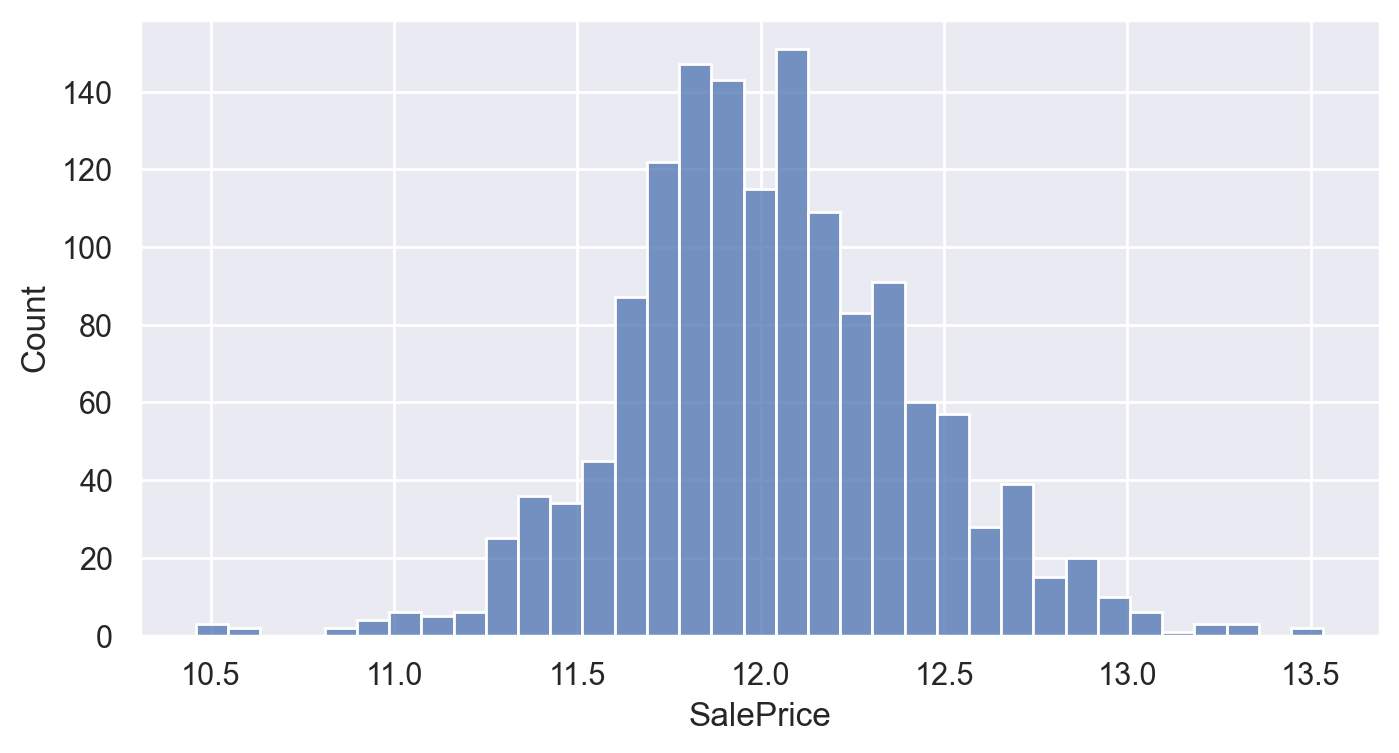

In [33]:
plt.figure(figsize=(8,4))
sns.histplot(data=data_feat, x="SalePrice")

También se ha observado que la relación de la variable `OveralQuality`, una de las más correlacionadas, era más fuerte con respecto al logaritmo de la variable `SalesPrice`.

Otra variable imortante, `GrLivArea`, también está sesgada. Sustituirla también por su logaritmo.

<AxesSubplot: xlabel='GrLivArea', ylabel='Count'>

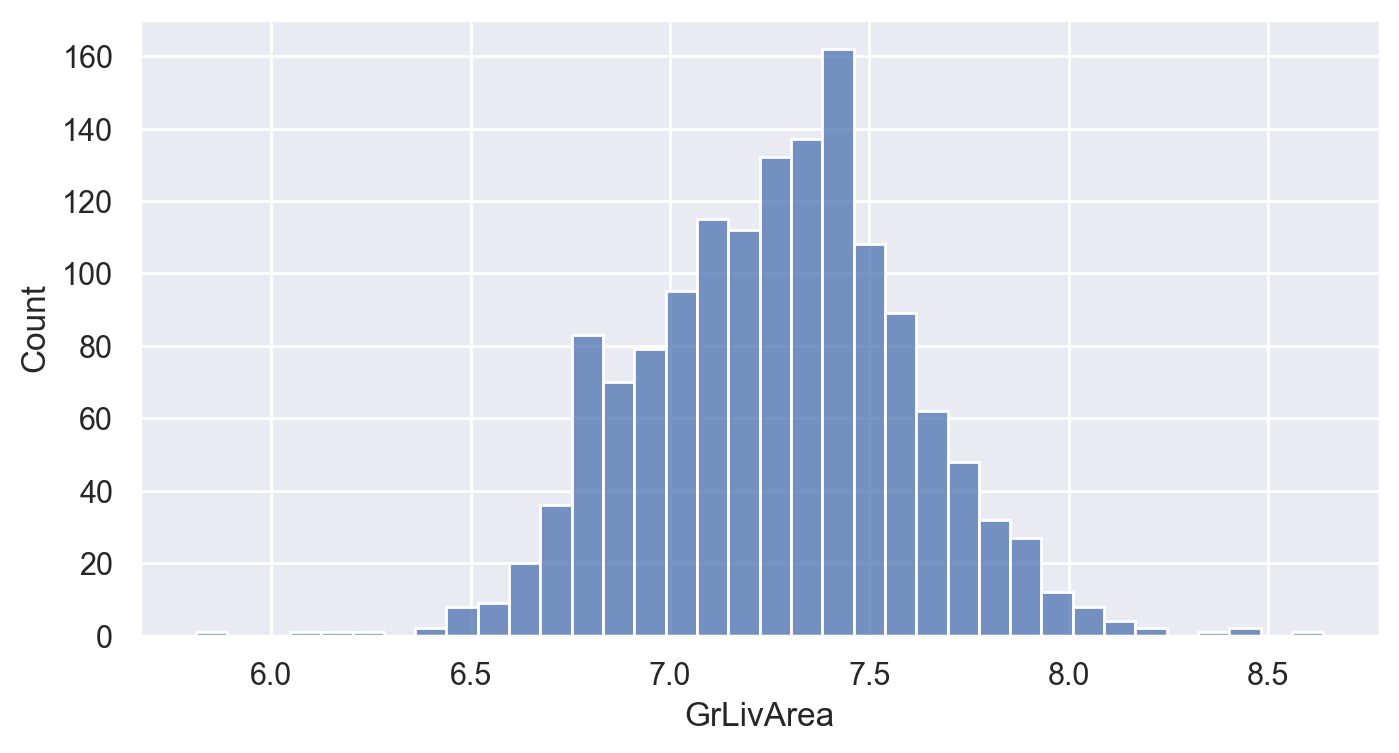

In [34]:
data_feat['GrLivArea'] = np.log(data_feat['GrLivArea'])
plt.figure(figsize=(8,4))
sns.histplot(data=data_feat, x="GrLivArea")

Por último, algunas variables numéricas representan datos temporales. Por ejemplo, en este conjunto de datos, el mes de venta. Aunque su repercursión no es muy fuerte, es conveniente saber tratar estas variables, ya que aparecen a menudo en distintos consumos de datos. A continuación se muestra la distribución de los precios en función del mes. 

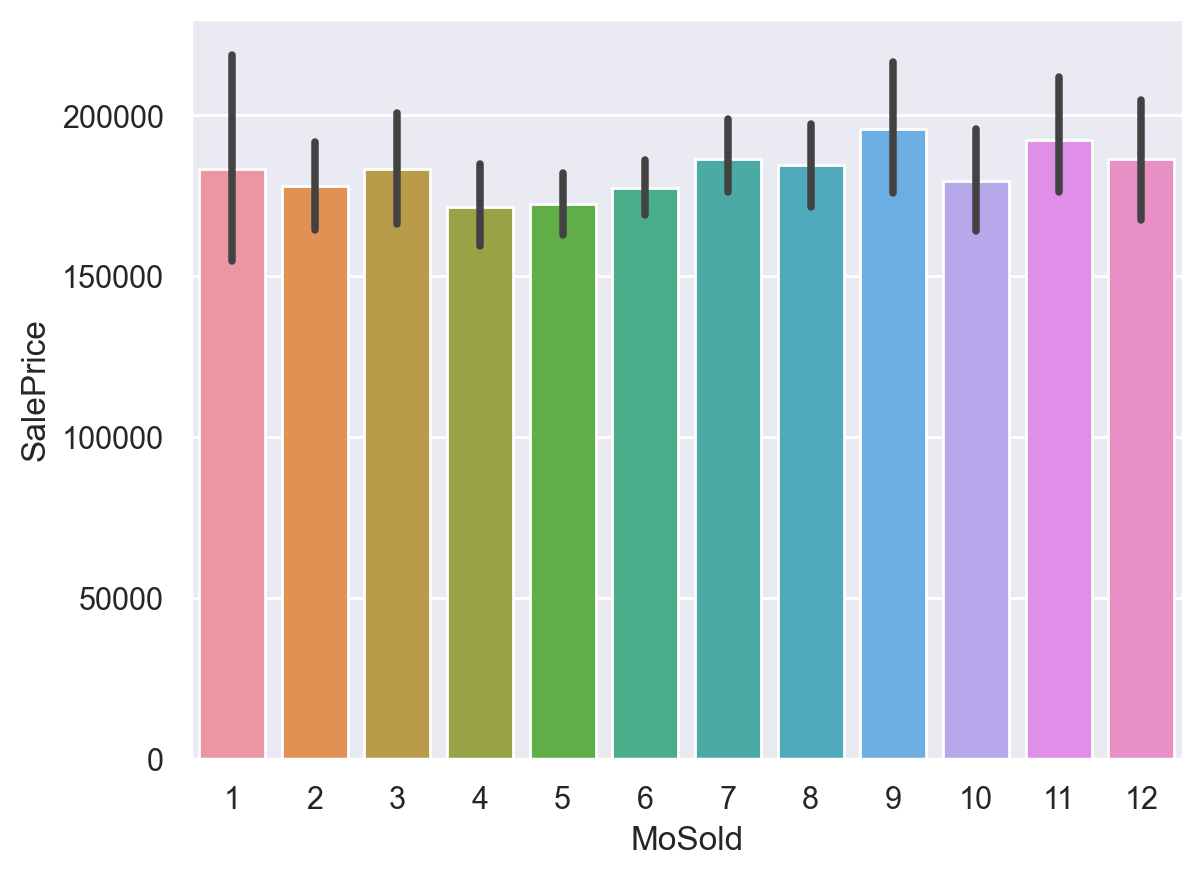

In [35]:
data_feat.sort_values(by='MoSold', inplace=True)
ax = sns.barplot(x=data_feat['MoSold'].astype('str'), y=data['SalePrice']);

Puede observarse que existe cierta oscilación en los precios y que depende del mes. También que el mes 1 y el 12, que representan valores extremos, realmente deberían ser similares, porque se suceden en el tiempo y, además, los precios medios son similares también. Vemos que los precios bajan en mayo y junio, y crecen en septiembre-noviembre. Estas particularidades no se representan mediante una relación lineal, pero se pueden representar mejor con una función sinusoidal.

(1.0, 13.0)

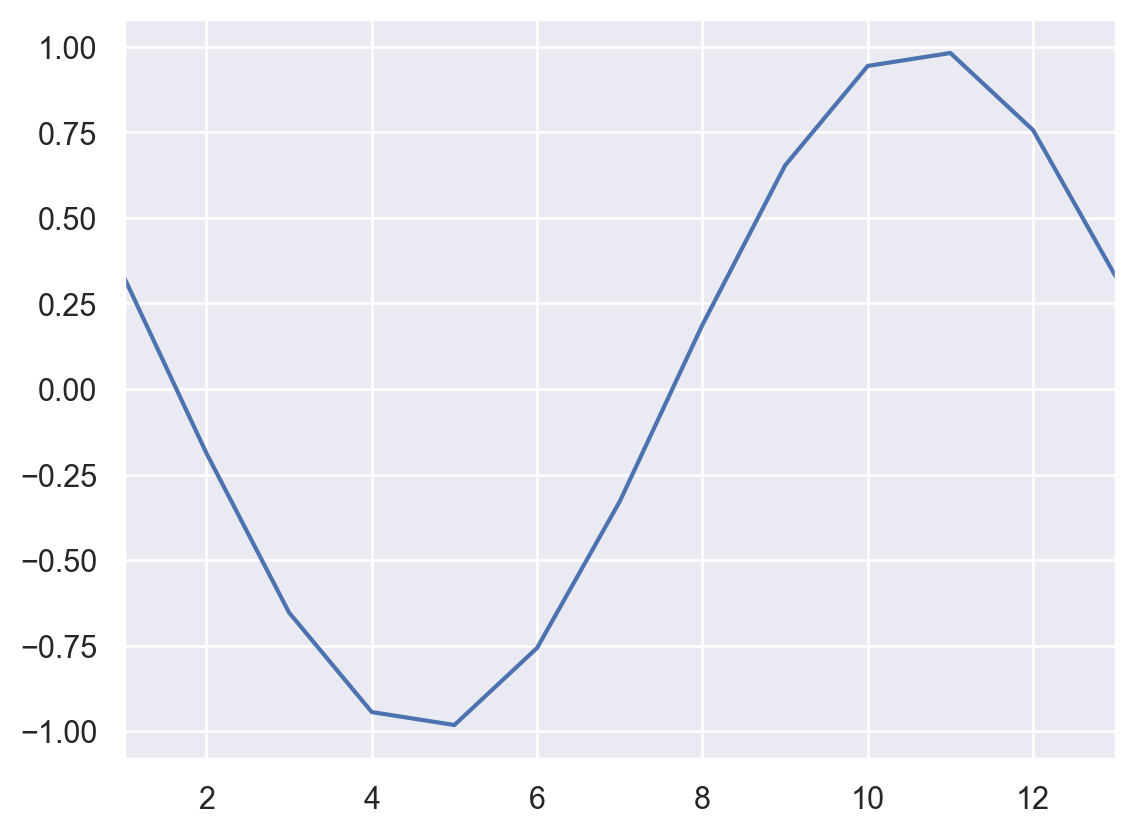

In [36]:
t = np.linspace(1,13, 13, endpoint=True)
ft = np.sin(2*np.pi*t/12-4)

plt.plot(t,ft)
plt.xlim(1,13)

Sustituir los valores de la columna `data_feat['MoSold']` por los obtenidos al calcular la función sinusoidal anterior.

In [37]:
data_feat['MoSold'] = np.sin(2*np.pi*data_feat['MoSold']/12-4)

<div><font size=3 color=#00586D> <i class="fa fa-check-square-o" aria-hidden="true"></i></font></div>

<!--comment -->

Una vez transformadas las tres variables, se volverán a obtener los conjuntos de entrenamiento y test, ahora con algunas características transformadas.

In [38]:
from sklearn.model_selection import train_test_split

X = data_feat.drop(columns='SalePrice').copy()
y = data_feat['SalePrice'].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)

#### <font color="#00586D"> <i class="fa fa-pencil-square-o" aria-hidden="true" ></i> Ejercicio 10</font> 

Volver a obtener los modelos de regresión lineal y árbol de regresión utilizando los conjuntos de datos obtenidos al transformar las características. Mostrar los resultados (visualizar el *DataFrame* `results`), y comentarlos.

<div class="alert alert-block alert-warning">
    
<i class="fa fa-exclamation-circle" aria-hidden="true"></i>
Como la variable `SalePrice` es ahora un logaritmo, es necesario deshacer esa transformación para hacer el MAE. Esto solo implica pasar el argumento `is_log=True` a la función `show_results`. 
<br>

Para KNN, utilizad el *pipeline* para estandarizar los datos, y solo las características incluídas en `relevant_feat`.
</div>

In [39]:
parameters = {'alpha':np.logspace(-4, 4, 9, endpoint=True)}
search = GridSearchCV(Ridge(), parameters,cv=5)
search = search.fit(X_train[relevant_feat], y_train)
print(search.best_params_, end='\n\n')

ridge = search.best_estimator_
description = 'Ridge regression (FT)'
show_results(description, ridge, X_train[relevant_feat], y_train, X_test[relevant_feat], y_test, True)

{'alpha': 1.0}

Training 		xValidation 		Test
-------- 		----------- 		----
R² = 0.885		R² = 0.875		R² = 0.804
MAE = 16580.30					MAE = 20909.14


In [40]:
parameters = {'max_depth':np.linspace(1,15,15), 'min_samples_split':(2,4,6,8,10)}
search = GridSearchCV(DecisionTreeRegressor(), parameters,cv=5)
search = search.fit(X_train[relevant_feat],y_train)
print(search.best_params_, end='\n\n')

tree = search.best_estimator_
description = 'Regression tree (FT)'
show_results(description, tree, X_train[relevant_feat], y_train, X_test[relevant_feat], y_test, True)

{'max_depth': 10.0, 'min_samples_split': 8}

Training 		xValidation 		Test
-------- 		----------- 		----
R² = 0.966		R² = 0.720		R² = 0.765
MAE = 9104.88					MAE = 24234.03


In [41]:
parameters = {'max_depth':[1,5,10,15,20]}
search = GridSearchCV(RandomForestRegressor(), parameters,cv=5)
search = search.fit(X_train[relevant_feat],y_train)
print(search.best_params_, end='\n\n')

rforest = search.best_estimator_
description = 'Random forest (FT)'
show_results(description, rforest, X_train[relevant_feat], y_train, X_test[relevant_feat], y_test, True)

{'max_depth': 20}

Training 		xValidation 		Test
-------- 		----------- 		----
R² = 0.980		R² = 0.855		R² = 0.855
MAE = 6857.65					MAE = 19089.04


In [42]:
pipe_knn = Pipeline([('scaler', StandardScaler()),('knn',KNeighborsRegressor())])
pipe_knn.fit(X_train[relevant_feat], y_train)

parameters = {'knn__n_neighbors':(1,5,10,15,20), 'knn__weights':('uniform','distance')}
search = GridSearchCV(pipe_knn, parameters, cv=5)
search = search.fit(X_train[relevant_feat],y_train)
print(search.best_params_, end='\n\n')
knn = search.best_estimator_

description = 'k-NN (STD - Relevant - FT)'
show_results(description, knn, X_train[relevant_feat], y_train, X_test[relevant_feat], y_test, True)

{'knn__n_neighbors': 10, 'knn__weights': 'distance'}

Training 		xValidation 		Test
-------- 		----------- 		----
R² = 1.000		R² = 0.841		R² = 0.825
MAE = 23.16					MAE = 21141.07


In [43]:
results

$R^2$ Entrenamiento  $R^2$ Validación  \
Modelo                                                               
Ridge regression                        0.907758          0.845827   
Regression tree                         0.875838          0.713737   
Random forest                           0.975114          0.854587   
Ridge regression (Relevant)             0.838920          0.826211   
Regression tree (Relevant)              0.952891          0.722274   
Random forest (Relevant)                0.979456          0.850222   
1-NN (Relevant)                         0.999983          0.502653   
1-NN (Relevant-STD)                     0.888893          0.815508   
k-NN (STD)                              1.000000          0.732469   
k-NN (STD - Relevant)                   0.999992          0.818755   
Ridge regression (FT)                   0.885228          0.874633   
Regression tree (FT)                    0.966492          0.719718   
Random forest (FT)                      0.979640          0.855396   
k-NN (STD - Relevant - FT)              0.999973          0.840812   

                             $R^2$ Test  MAE Entrenamiento      MAE Test  
Modelo                                                                    
Ridge regression               0.775932       15187.837606  19274.550173  
Regression tree                0.734017       20723.767792  26399.467551  
Random forest                  0.856982        7938.229264  17124.295203  
Ridge regression (Relevant)    0.716225       20409.525417  21976.678936  
Regression tree (Relevant)     0.684827       13021.630030  24963.960631  
Random forest (Relevant)       0.860595        6744.088366  17421.191491  
1-NN (Relevant)                0.609653          14.670757  32802.022822  
1-NN (Relevant-STD)            0.781668       16135.719632  20657.930705  
k-NN (STD)                     0.698286           0.006717  25710.122559  
k-NN (STD - Relevant)          0.782958          14.671581  20628.614990  
Ridge regression (FT)          0.803730       16580.298901  20909.141558  
Regression tree (FT)           0.764551        9104.879880  24234.030408  
Random forest (FT)             0.855070        6857.649877  19089.037874  
k-NN (STD - Relevant - FT)     0.825370          23.159019  21141.073720

___Comentario___
<br>

Después de transformar las variables podemos observar que en comparación a los datos obtenidos inicialmente el valor de Ridge empeora en entrenamiento pero mejora en validación, mientras que regression tree mejora en entrenamiento y empeora ligeramente en validacion. Random forest mantiene sus valores en ambos casos y KNN mejora su valor en validación.
<br>
En comparacion a los modelos obtenidos con los datos relevantes, cuando transformamos las variables se observa que Ridge aumenta su valor para entrenamiento y validacion, random forest y regression tree mejoran su valor para la validacion,al igual que KNN 

<div><font size=3 color=#00586D> <i class="fa fa-check-square-o" aria-hidden="true"></i></font></div>

<!--comment -->

<div align="right">
<a href="#indice"><font size=5 color="#00586D"><i class="fa fa-arrow-circle-up" aria-hidden="true"></i></font></a>
</div>

---

<a id="section9"></a>
## <font color="#00586D"> 9. Descarte de outliers</font>
<br>

Llegado a este punto se aprecia que el mejor resultado se ha obtenido con la regresión regularizada (nos basamos en la validación para la selección de modelos), tras transformar algunas características, y utilizando todas las demás.  En algunos casos, los valores anómalos pueden perjudicar al modelo. En regresión, por ejemplo, pueden hacer que algún coeficiente se altere de manera sustancial, sobre todo si el conjunto de datos no es grande.

Por último, se comprobará el efecto de eliminar valores anómalos. 




#### <font color="#00586D"> <i class="fa fa-pencil-square-o" aria-hidden="true" ></i> Ejercicio 11</font> 

Utilizar un modelo *Isolation Forest* para "marcar" las muestras que son *outliers*, tanto en el conjunto de entrenamiento como en el conjunto de test. Utilizar una contaminación del 0.5%.  Generar dos vectores (`out_train` y `out_test`) con los resultados (1 para valores normales, y -1 para *outliers*). ¿Cuantos *outliers* hay en el conjunto de entrenamiento? ¿Y en el de test?

In [44]:
from sklearn.ensemble import IsolationForest
import collections

iforest =  IsolationForest(contamination=0.5).fit(X_train.values)

out_train = iforest.predict(X_train.values)

out_test =  iforest.predict(X_test.values)
print("train:",collections.Counter(out_train)[-1],"test:",collections.Counter(out_test)[-1])

train: 489 test: 252


<div><font size=3 color=#00586D> <i class="fa fa-check-square-o" aria-hidden="true"></i></font></div>

<!--comment -->

#### <font color="#00586D"> <i class="fa fa-pencil-square-o" aria-hidden="true" ></i> Ejercicio 12</font> 

Eliminar los outliers  de los conjuntos de entrenamiento y test, y entrenar el modelo de regresión lineal regularizada (el mejor modelo hasta el momento). ¿Qué resultados se obtienen?

In [45]:
X_train_cleaned = X_train[np.where(out_train == 1, True, False)]
y_train_cleaned = y_train[np.where(out_train == 1, True, False)]
X_test_cleaned = X_test[np.where(out_test == 1, True, False)]
y_test_cleaned = y_test[np.where(out_test == 1, True, False)]

In [46]:
parameters = {'alpha':np.logspace(-4, 4, 9, endpoint=True)}
search = GridSearchCV(Ridge(), parameters,cv=5).fit(X_train_cleaned, y_train_cleaned)
print(search.best_params_, end='\n\n')

ridge = search.best_estimator_
description = 'Ridge regression (FT - No Outliers)'
show_results(description, ridge, X_train_cleaned, y_train_cleaned, X_test_cleaned, y_test_cleaned, True)

{'alpha': 10.0}

Training 		xValidation 		Test
-------- 		----------- 		----
R² = 0.948		R² = 0.914		R² = 0.891
MAE = 8614.45					MAE = 10423.59


In [47]:
results

$R^2$ Entrenamiento  $R^2$ Validación  \
Modelo                                                                       
Ridge regression                                0.907758          0.845827   
Regression tree                                 0.875838          0.713737   
Random forest                                   0.975114          0.854587   
Ridge regression (Relevant)                     0.838920          0.826211   
Regression tree (Relevant)                      0.952891          0.722274   
Random forest (Relevant)                        0.979456          0.850222   
1-NN (Relevant)                                 0.999983          0.502653   
1-NN (Relevant-STD)                             0.888893          0.815508   
k-NN (STD)                                      1.000000          0.732469   
k-NN (STD - Relevant)                           0.999992          0.818755   
Ridge regression (FT)                           0.885228          0.874633   
Regression tree (FT)                            0.966492          0.719718   
Random forest (FT)                              0.979640          0.855396   
k-NN (STD - Relevant - FT)                      0.999973          0.840812   
Ridge regression (FT - No Outliers)             0.948185          0.913619   

                                     $R^2$ Test  MAE Entrenamiento  \
Modelo                                                               
Ridge regression                       0.775932       15187.837606   
Regression tree                        0.734017       20723.767792   
Random forest                          0.856982        7938.229264   
Ridge regression (Relevant)            0.716225       20409.525417   
Regression tree (Relevant)             0.684827       13021.630030   
Random forest (Relevant)               0.860595        6744.088366   
1-NN (Relevant)                        0.609653          14.670757   
1-NN (Relevant-STD)                    0.781668       16135.719632   
k-NN (STD)                             0.698286           0.006717   
k-NN (STD - Relevant)                  0.782958          14.671581   
Ridge regression (FT)                  0.803730       16580.298901   
Regression tree (FT)                   0.764551        9104.879880   
Random forest (FT)                     0.855070        6857.649877   
k-NN (STD - Relevant - FT)             0.825370          23.159019   
Ridge regression (FT - No Outliers)    0.890645        8614.448834   

                                         MAE Test  
Modelo                                             
Ridge regression                     19274.550173  
Regression tree                      26399.467551  
Random forest                        17124.295203  
Ridge regression (Relevant)          21976.678936  
Regression tree (Relevant)           24963.960631  
Random forest (Relevant)             17421.191491  
1-NN (Relevant)                      32802.022822  
1-NN (Relevant-STD)                  20657.930705  
k-NN (STD)                           25710.122559  
k-NN (STD - Relevant)                20628.614990  
Ridge regression (FT)                20909.141558  
Regression tree (FT)                 24234.030408  
Random forest (FT)                   19089.037874  
k-NN (STD - Relevant - FT)           21141.073720  
Ridge regression (FT - No Outliers)  10423.594998

___Comentario___
<br>

Podemos observar que al eliminar los outliers el R2 para entrenamiento y validación aumentan de manera considerable en el modelo de Ridge y que por tanto es el mejor método
<br>

<div><font size=3 color=#00586D> <i class="fa fa-check-square-o" aria-hidden="true"></i></font></div>

<!--comment -->

<div class="alert alert-block alert-warning">
    
<i class="fa fa-exclamation-circle" aria-hidden="true"></i>
__Importante__: Incorporar este paso al pipeline sería bastante complejo porque no solo modificamos columnas, sino que eliminamos filas. Habría que hacer un *metaclasificador* que primero determine si un valor es un outlier o no, y en función de eso devuelva el resultado (que puede ser -1 para un caso, y la predicción para otro). La implementación de este *pipeline* constituye un ejercicio interesante.
</div>

<div align="right">
<a href="#indice"><font size=5 color="#00586D"><i class="fa fa-arrow-circle-up" aria-hidden="true"></i></font></a>
</div>

---

<a id="section10"></a>
## <font color="#00586D">10. Aprendizaje no supervisado: PCA, Manifold y EM</font>
<br>

Para analizar el conjunto de datos mediante aprendizaje no supervisado se partirá del conjunto de datos original. En este caso trabajaremos solamente con las caracterícticas numéricas más relevantes y el precio.

<div class="alert alert-block alert-info">
    
<i class="fa fa-info-circle" aria-hidden="true"></i> Estos ejercicios **no son una continuación** de los relacionados con el modelo predictivo, sino que constituyen una estudio independiente. 
</div>

In [48]:
feat = ['OverallQual',
        'GrLivArea',
        'ExterQual',
        'KitchenQual',
        'GarageArea',
        'TotalBsmtSF',
        '1stFlrSF',
        'TotRmsAbvGrd',
        'YearBuilt',
        'SalePrice']

data_small = data[feat]
data_small.head()

OverallQual  GrLivArea  ExterQual  KitchenQual  GarageArea  TotalBsmtSF  \
Id                                                                            
1             7       1710          4            4         548          856   
2             6       1262          3            3         460         1262   
3             7       1786          4            4         608          920   
4             7       1717          3            4         642          756   
5             8       2198          4            4         836         1145   

    1stFlrSF  TotRmsAbvGrd  YearBuilt  SalePrice  
Id                                                
1        856             8       2003     208500  
2       1262             6       1976     181500  
3        920             6       2001     223500  
4        961             7       1915     140000  
5       1145             9       2000     250000

#### <font color="#00586D"> <i class="fa fa-pencil-square-o" aria-hidden="true" ></i> Ejercicio 13</font>

Utilizar PCA para reducir la dimensionalidad del conjunto de datos `data`. Utilizar dos componentes y almacenar la proyección en una variable denominada `data_pc`. Mostrar la proporción de varianza mostrada por cada componente. Dibujar una gráfica de dispersión con los valores de las dos primeras características creadas (proyecciones correspondientes a las dos componentes). ¿Qué se observa? (Se puede utilizar como color, por ejemplo, `hue=data['SalePrice']`).

In [49]:
from sklearn.decomposition import PCA

pca =  PCA(n_components = 2).fit(data_small)
data_pc =  pca.transform(data_small)

print(f'Número de componentes: {data_pc.shape[1]}')

Número de componentes: 2


In [50]:
cumVar = pd.DataFrame(np.cumsum(pca.explained_variance_ratio_)*100, 
                      columns=["Varianza acumulada"])
expVar = pd.DataFrame(pca.explained_variance_ratio_*100, columns=["% Varianza"])
pd.concat([expVar, cumVar], axis=1)\
    .rename(index={0: "PC1", 1: "PC2"})

% Varianza  Varianza acumulada
PC1   99.993969           99.993969
PC2    0.003074           99.997043

[Text(0.5, 0, 'PC1'), Text(0, 0.5, 'PC2')]

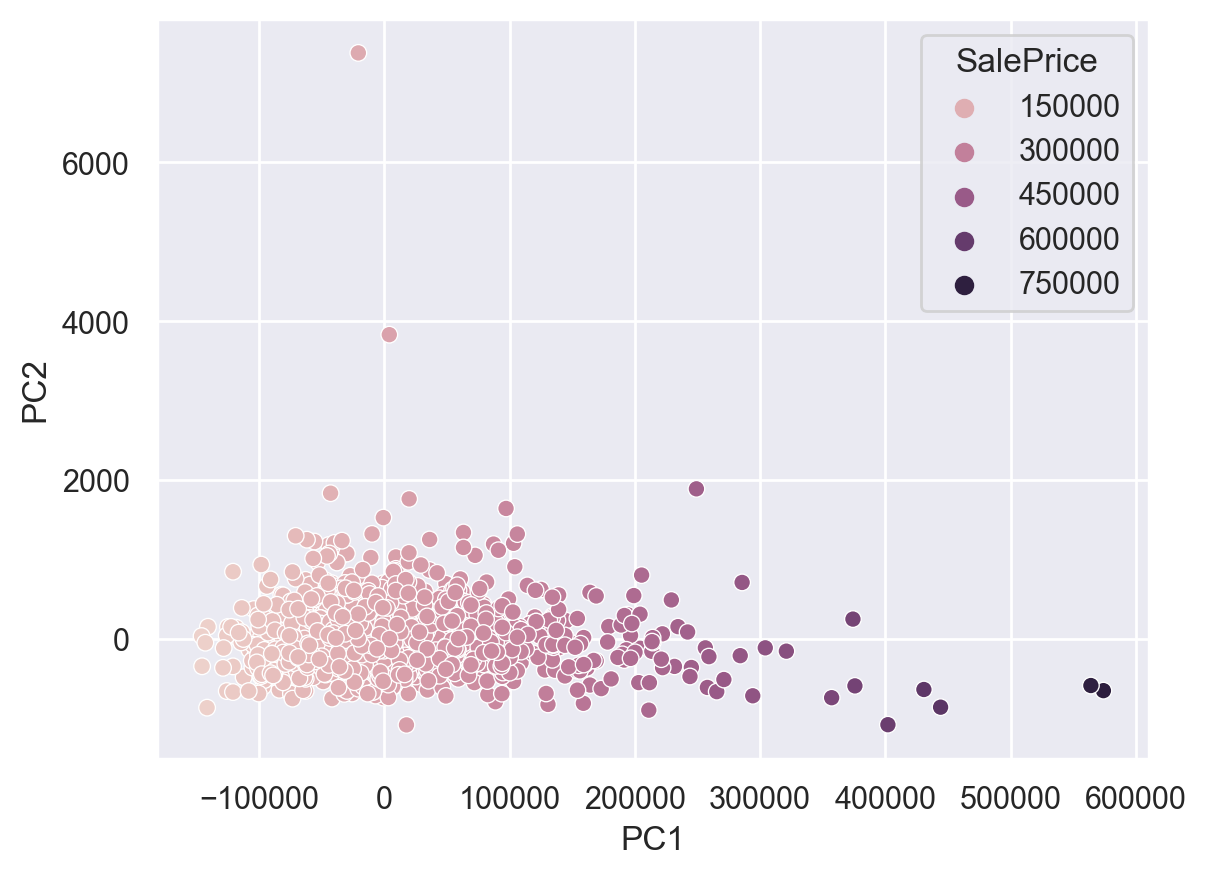

In [52]:
ax = sns.scatterplot(data=data_pc, x = data_pc[:,0], y = data_pc[:,1], hue=data['SalePrice'])
ax.set(xlabel='PC1', ylabel='PC2')

Muestra las cargas de las dos componentes (los 5 valores más importantes)

In [53]:
sorted(zip(data_small.columns,pca.components_[0]), key=lambda pair: pair[1], reverse=True)[:5]

[('SalePrice', 0.9999775001384428),
 ('GrLivArea', 0.0046872803213563775),
 ('TotalBsmtSF', 0.003388405536137292),
 ('1stFlrSF', 0.002948274914306237),
 ('GarageArea', 0.0016778322625515395)]

In [54]:
sorted(zip(data_small.columns,pca.components_[1]), key=lambda pair: pair[1], reverse=True)[:5]

[('TotalBsmtSF', 0.6791609607994268),
 ('1stFlrSF', 0.6292308359316409),
 ('GrLivArea', 0.3688814659467983),
 ('GarageArea', 0.0817958738329799),
 ('TotRmsAbvGrd', 0.000798014515819715)]

In [55]:
#Completar

___Comentario___
<br>

A partir de los resultados obtenidos comprobamos que utilizando solo dos componentes el porcentaje de varianza cumulativa que se obtiene entre las dos es del 99.997%, teniendo la primera componente una varianza de 99.993% y la segunda un 0.033%. Observamos también que la carga de la primera componente se localiza en la variable SalePrice con un 99.99% de carga, y la carga de la segunda componente reside mayoritariamente en la variable TotalBsmtSF con un 67.91% de carga.
<br>
A partir del grafico de dispersion se observa que conforme aumentan los valores de PC1 disminuye el valor de SalePrice y que la variable PC1 es la que explica la variacion para SalePrice

<div><font size=3 color=#00586D> <i class="fa fa-check-square-o" aria-hidden="true"></i></font></div>

<!--comment -->

#### <font color="#00586D"> <i class="fa fa-pencil-square-o" aria-hidden="true" ></i> Ejercicio 14</font>




Construir un *pipeline* en el que el primer paso consista en escalar las características a media cero y desviación uno mediante un objeto `StandardScaler`, y después se  repita el proceso anterior, almacenando la proyección de los datos en `data_pc`. Mostrar el número de componentes necesarias para retener el 99% de la varianza de los datos. ¿Son ahora tan relevantes las dos primeras componentes? ¿Por qué? ¿Cuánta varianza acumulan? ¿Podrían interpretarse de algún modo?

In [56]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline


pipe_sc_pca =  Pipeline([('scaler', StandardScaler()),('PCA', PCA(0.99))]).fit(data_small)
data_pc =  pipe_sc_pca.transform(data_small)
pca =  pipe_sc_pca["PCA"]

print(f'Número de componentes: {data_pc.shape[1]}')

Número de componentes: 10


In [57]:
cumVar = pd.DataFrame(np.cumsum(pipe_sc_pca["PCA"].explained_variance_ratio_)*100, 
                      columns=["Varianza acumulada"])
expVar = pd.DataFrame(pipe_sc_pca["PCA"].explained_variance_ratio_*100, columns=["% Varianza"])
pd.concat([expVar, cumVar], axis=1)

% Varianza  Varianza acumulada
0   56.500482           56.500482
1   13.860714           70.361196
2    9.554296           79.915492
3    5.492570           85.408061
4    4.241023           89.649085
5    3.046287           92.695371
6    2.615223           95.310594
7    1.860004           97.170598
8    1.568184           98.738782
9    1.261218          100.000000

In [59]:
sorted(zip(data_small.columns,pca.components_[0]), key=lambda pair: pair[1], reverse=True)[:5]

[('SalePrice', 0.38282241839673714),
 ('OverallQual', 0.3620513765232636),
 ('ExterQual', 0.33080533313143906),
 ('KitchenQual', 0.31772664306577736),
 ('GrLivArea', 0.3175407833217904)]

In [60]:
sorted(zip(data_small.columns,pca.components_[1]), key=lambda pair: pair[1], reverse=True)[:5]

[('TotRmsAbvGrd', 0.5520895000574143),
 ('GrLivArea', 0.4624729140363184),
 ('1stFlrSF', 0.2329906471470696),
 ('TotalBsmtSF', 0.05481998035143698),
 ('SalePrice', 0.026981868237818233)]

___Comentario___
<br>

A partir del estudio realizado anteriormente observamos que para obtener un 99% de varianza acumulada en los datos necesitamos 10 componentes. Al utilizar 10 componentes se percibe que la varianza acumulada para las dos primeras componentes es de un 70.36%, teniendo la primera componente una varianza de 56.5% y la segunda una varianza de 13.86%. Observamos que las cargas de las dos primeras componentes son iguales que anteriormente, pero en este caso éstas ocupan una varianza mucho menor que en el caso anterior.
Esta diferencia de varianza es debida a el primer paso del pipeline, en el cual se escalan las características a media cero y desviación 1. Ese primer paso del pipeline hace que los datos de entrenamiento pasen por un scaler y por ello los resultados sean diferentes a cuando aplicamos pca directamente sin escalar los datos
<br>


<div><font size=3 color=#00586D> <i class="fa fa-check-square-o" aria-hidden="true"></i></font></div>

<!--comment -->

#### <font color="#00586D"> <i class="fa fa-pencil-square-o" aria-hidden="true" ></i> Ejercicio 15</font>

Repetir el ejercicio anterior, pero utilizando ahora TSNE. Para ello, crear un *pipeline* en el que el primer paso corresponda a la estadarización, y el segundo a un modelo TSNE en el que `n_components=2`. Utilizarlo para transformar los datos en `data_small` y almacenar el resultado en un array denominado `data_vis`.

In [61]:
from sklearn.manifold import TSNE

pipe_sc_tsne = Pipeline([('scaler', StandardScaler()),('TNSE', TSNE(n_components = 2))])
data_vis = pipe_sc_tsne.fit_transform(data_small)

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.


Elaborar una gráfica de dispersión con los datos de `data_vis`.

In [62]:
#Para representar estos gráficos he utilizado la función scatter ya que me parecía que se visualizaba mejor en este caso

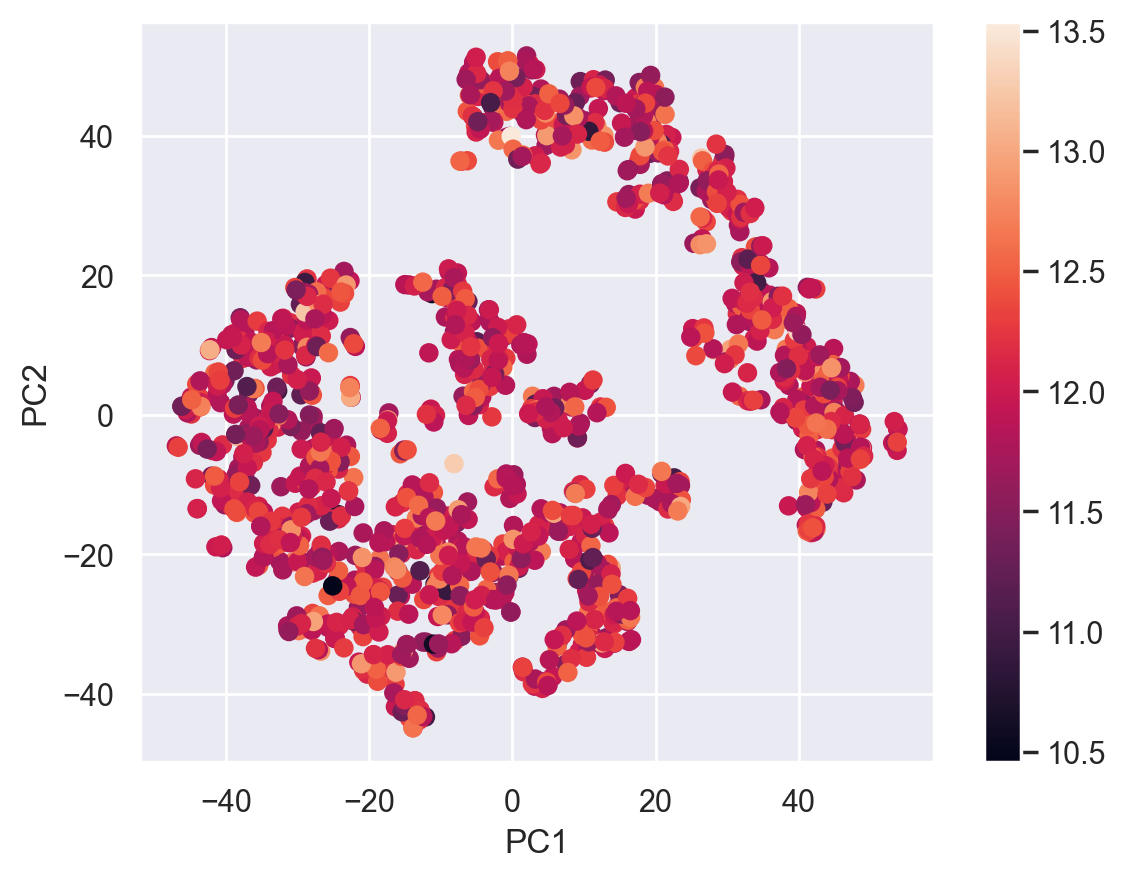

In [63]:
sc=plt.scatter(data_vis[:,0], data_vis[:,1], c = y)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.colorbar(sc)
plt.show()

Repetir la gráfica, pero utilizando `hue=data['SalePrice']` 

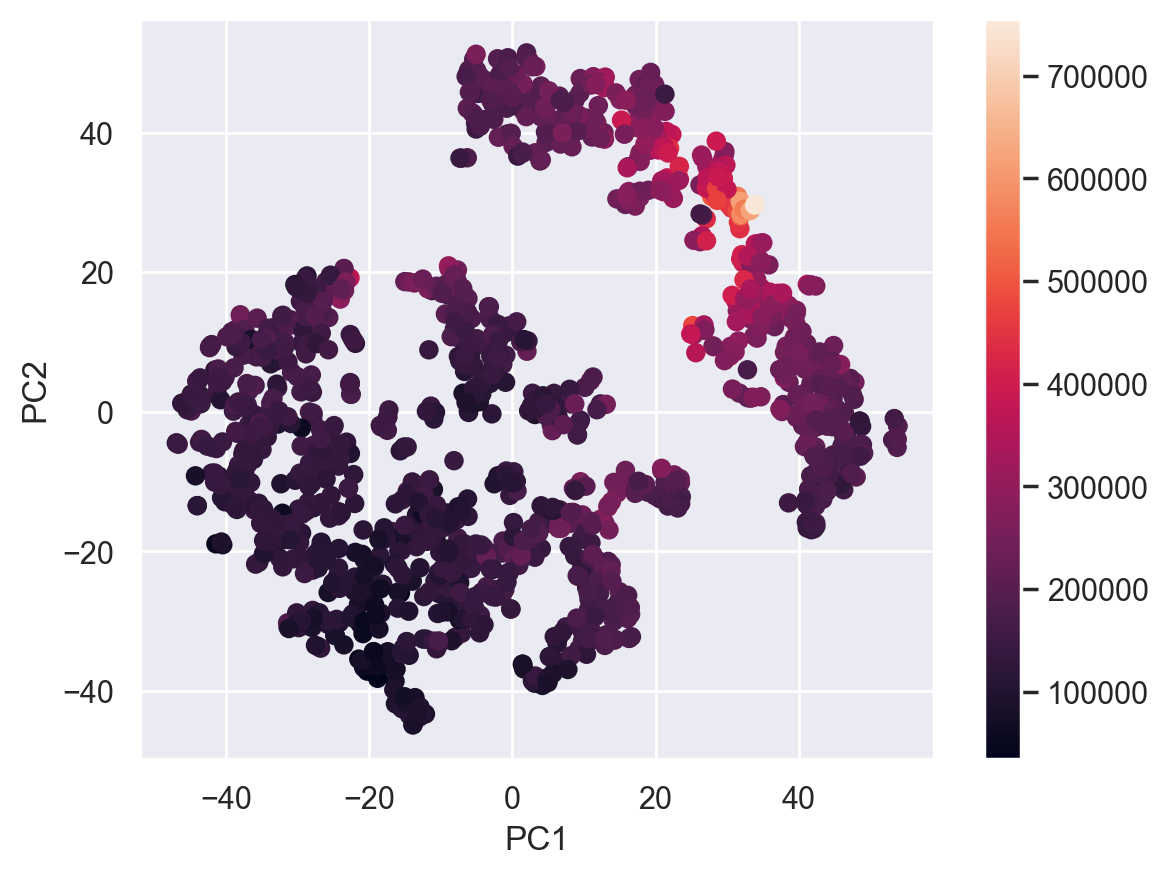

In [64]:
sc=plt.scatter(data_vis[:,0], data_vis[:,1], c = data['SalePrice'])
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.colorbar(sc)
plt.show()

Probar a utilizar el color para mostrar otra variables, como por ejemplo `YearBuilt`.

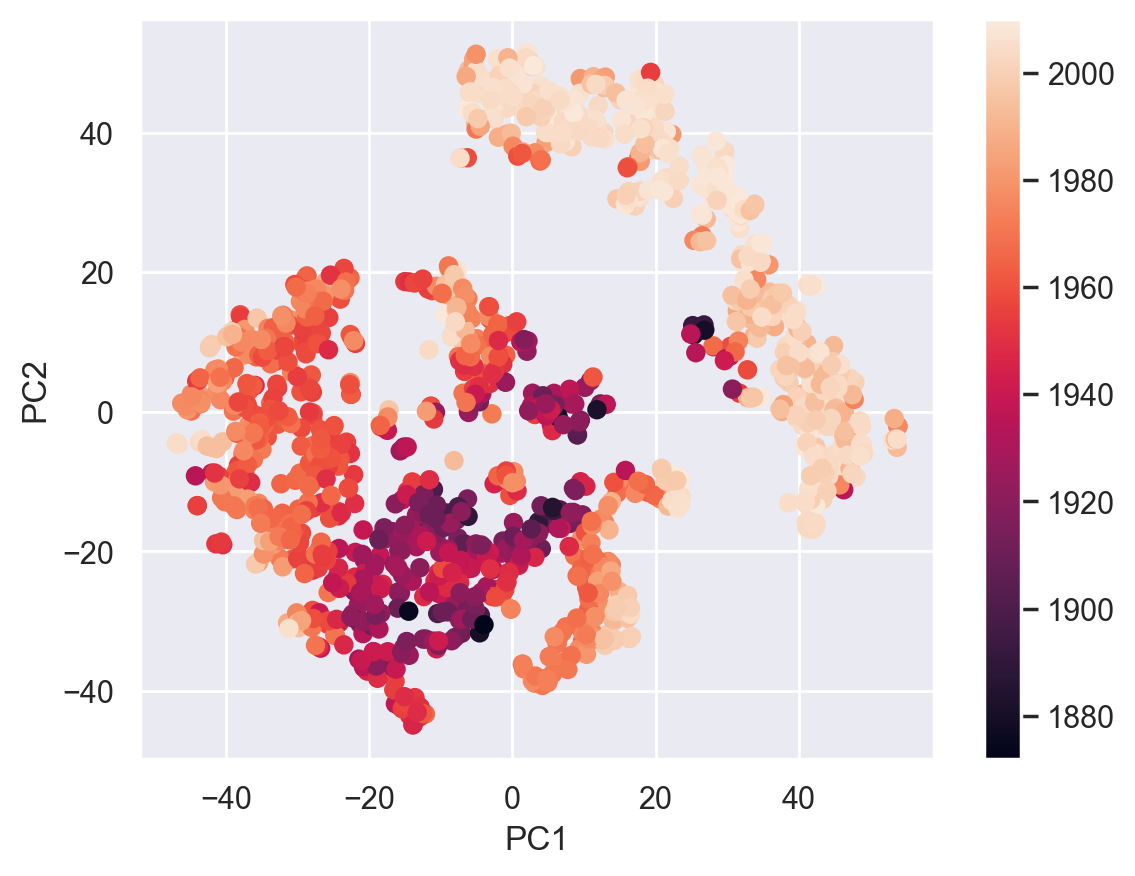

In [65]:
sc=plt.scatter(data_vis[:,0], data_vis[:,1], c = data['YearBuilt'])
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.colorbar(sc)
plt.show()

___Comentario___
<br>

A partir de los gráficos de dispersión observamos que cuando utilizamos la escala de color SalePice, el valor de la variable aumenta conforme aumentan los valores de PC1 y PC2, obteniendo el valor más alto en PC1 = 40 y PC2 = 22.
Para el gráfico en el que el color se define por la variable YearBuilt se observan 3 zonas, una ubicada a la derecha en la cual la variable adquiere los valores más altos cuando PC1 y PC2 poseen también valores altos, otra ubicada en el centro del cuadrante que está entre los valores PC1=[20,-40] y PC2=[20,-40] la cuál posee valores bajos para la variable YearBuilt, y la tercera zona la cual se ubica rodeando el centro del cuadrante, en la cual los valores de la variable YearBuilt son medios (entre 1960 y 1980).
<br>

<div><font size=3 color=#00586D> <i class="fa fa-check-square-o" aria-hidden="true"></i></font></div>

<!--comment -->

#### <font color="#00586D"> <i class="fa fa-pencil-square-o" aria-hidden="true" ></i> Ejercicio 16</font>

Por último, se va a utilizar el algoritmo EM (modelo `GaussianMixture`) para representar la distribución de las viviendas que hay en `data_small`, y utilizando `n_components=2`.   En este caso, también es necesario utilizar un *pipeline* en el que el primer paso consista en una estandarización, y el segundo el propio algoritmo. Almacenar el cluster al que pertenece cada vivienda en `cluster`.

In [66]:
from sklearn.mixture import GaussianMixture

pipe_sc_gm = Pipeline([('scaler', StandardScaler()),('GaussianMixture', GaussianMixture(n_components = 2))]).fit(data_small)
cluster = pipe_sc_gm.predict(data_small)

Obtener la media de todas las columnas para cada uno de los grupos y compararlos. ¿Puede hacerse algún tipo de interpretación?

In [67]:
Means = pd.DataFrame(pipe_sc_gm["GaussianMixture"].means_.T, columns=["PC1","PC2"])
Means

PC1       PC2
0  0.825577 -0.506989
1  0.494737 -0.303820
2  1.122945 -0.689604
3  0.819113 -0.503020
4  0.568552 -0.349150
5  0.503288 -0.309071
6  0.404117 -0.248169
7  0.310782 -0.190852
8  0.750922 -0.461144
9  0.755603 -0.464018

Otra forma de interpretar los clusters es mediante visualización. Mostrar una gráfica de dispersión con las columnas `GrLivArea` y `SalePrice`. Utilizar  `hue=cluster`. ¿Puede hacerse algún tipo de interpretación? 

[Text(0.5, 0, 'PC1'), Text(0, 0.5, 'PC2')]

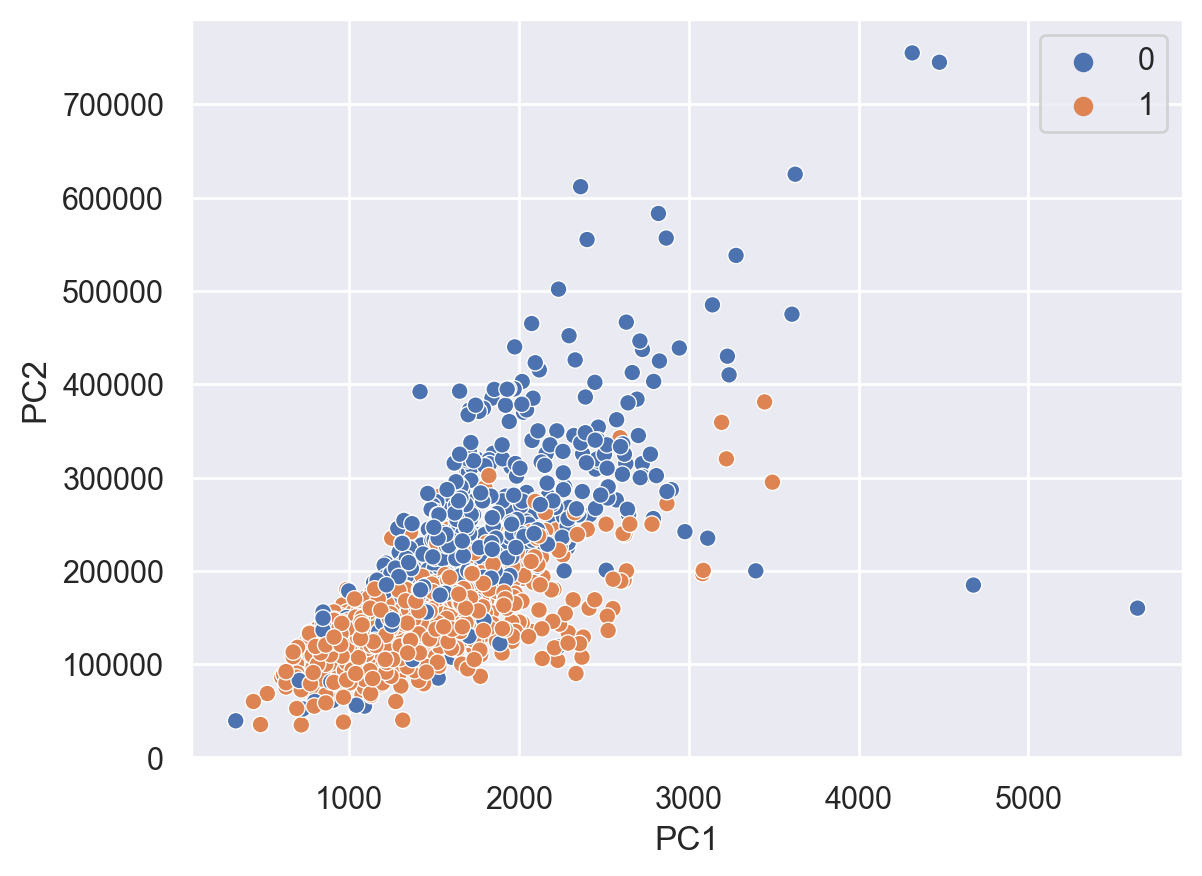

In [68]:
ax = sns.scatterplot(data=data_small, x = "GrLivArea", y = "SalePrice", hue=cluster)
ax.set(xlabel='PC1', ylabel='PC2')

Elaborar ahora una gráfica de dispersión, pero con los datos de `data_pc`, utilizando otra vez `hue=cluster`. ¿Puede hacerse algún tipo de interpretación? 

[Text(0.5, 0, 'PC1'), Text(0, 0.5, 'PC2')]

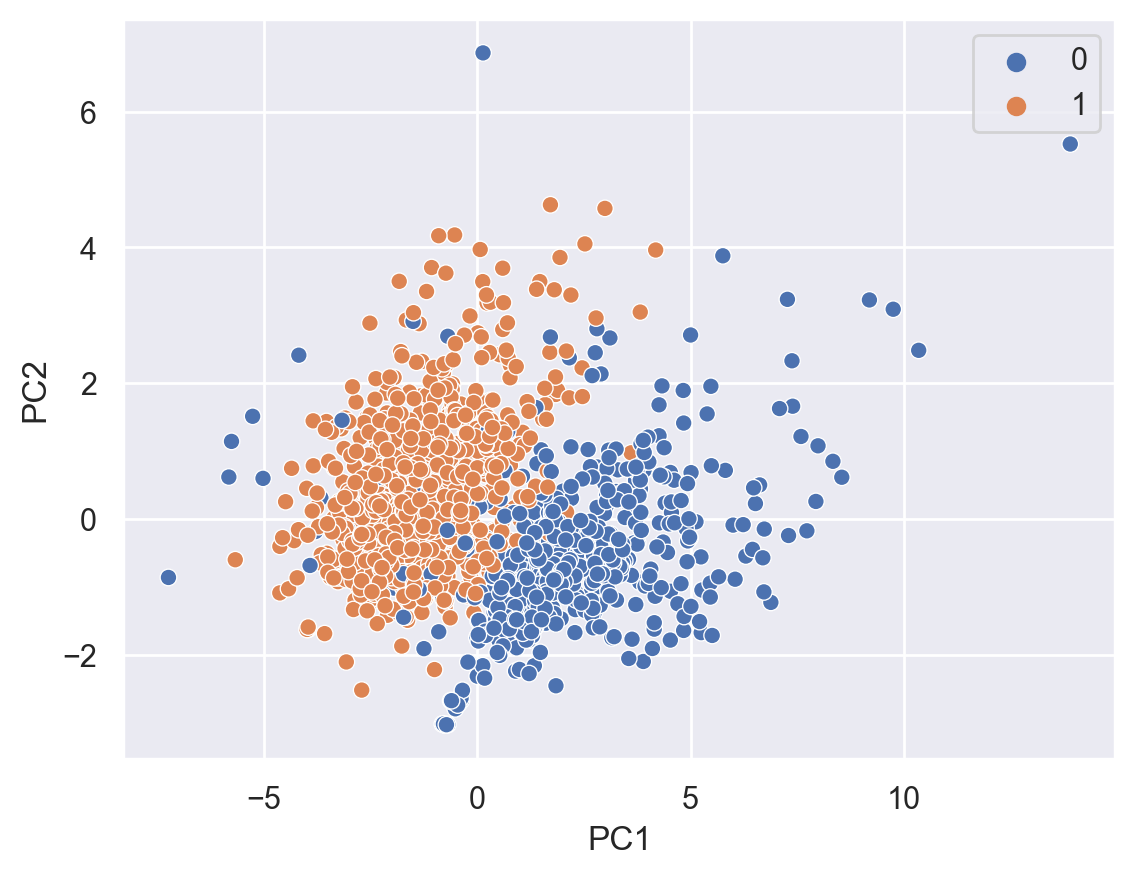

In [69]:
ax = sns.scatterplot(data=data_pc, x=data_pc[:,0], y=data_pc[:,1], hue=cluster)
ax.set(xlabel='PC1', ylabel='PC2')

Repetir la gráfica, pero con los datos en `data_vis`. ¿Puede hacerse algún tipo de interpretación? 

[Text(0.5, 0, 'PC1'), Text(0, 0.5, 'PC2')]

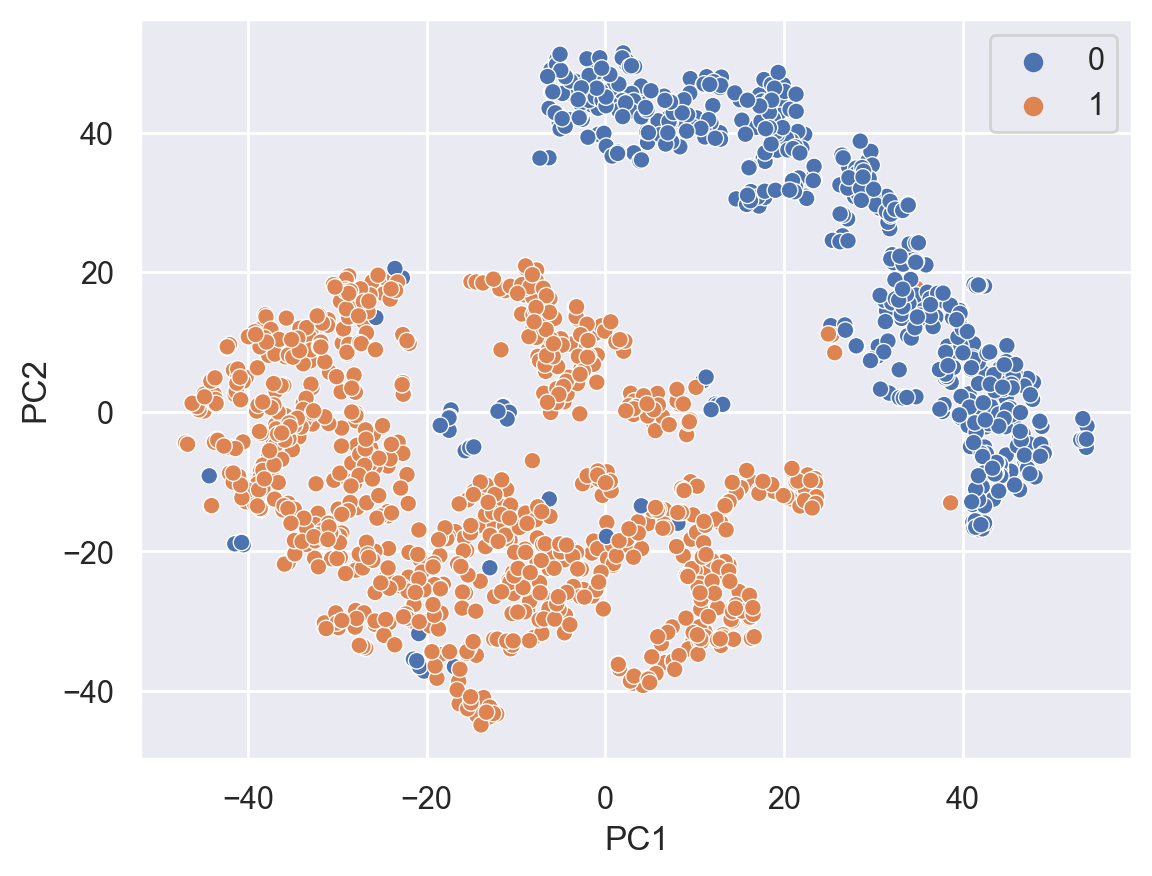

In [70]:
ax = sns.scatterplot(data=data_vis, x=data_vis[:,0], y=data_vis[:,1], hue=cluster)
ax.set(xlabel='PC1', ylabel='PC2')

___Comentario___
<br>

Al utilizar hue=cluster se observa que se generan dos grupos distinguidos para los datos de data_vis, mientras que para data_small y data_pc los grupos tienden a solaparse. Eso puede significar que el modelo GaussianMixture es capaz de clasificar datos ya transformados con TSNE
<br>

<div><font size=3 color=#00586D> <i class="fa fa-check-square-o" aria-hidden="true"></i></font></div>

<!--comment -->

<div align="right">
<a href="#indice"><font size=5 color="#00586D"><i class="fa fa-arrow-circle-up" aria-hidden="true"></i></font></a>
</div>

---

<div align="right">
<a href="#indice"><font size=6 color="#00586D"><i class="fa fa-coffee" aria-hidden="true"></i></font></a>
</div>